10
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 1.0070007286810243
R² score: -7.898558035104783


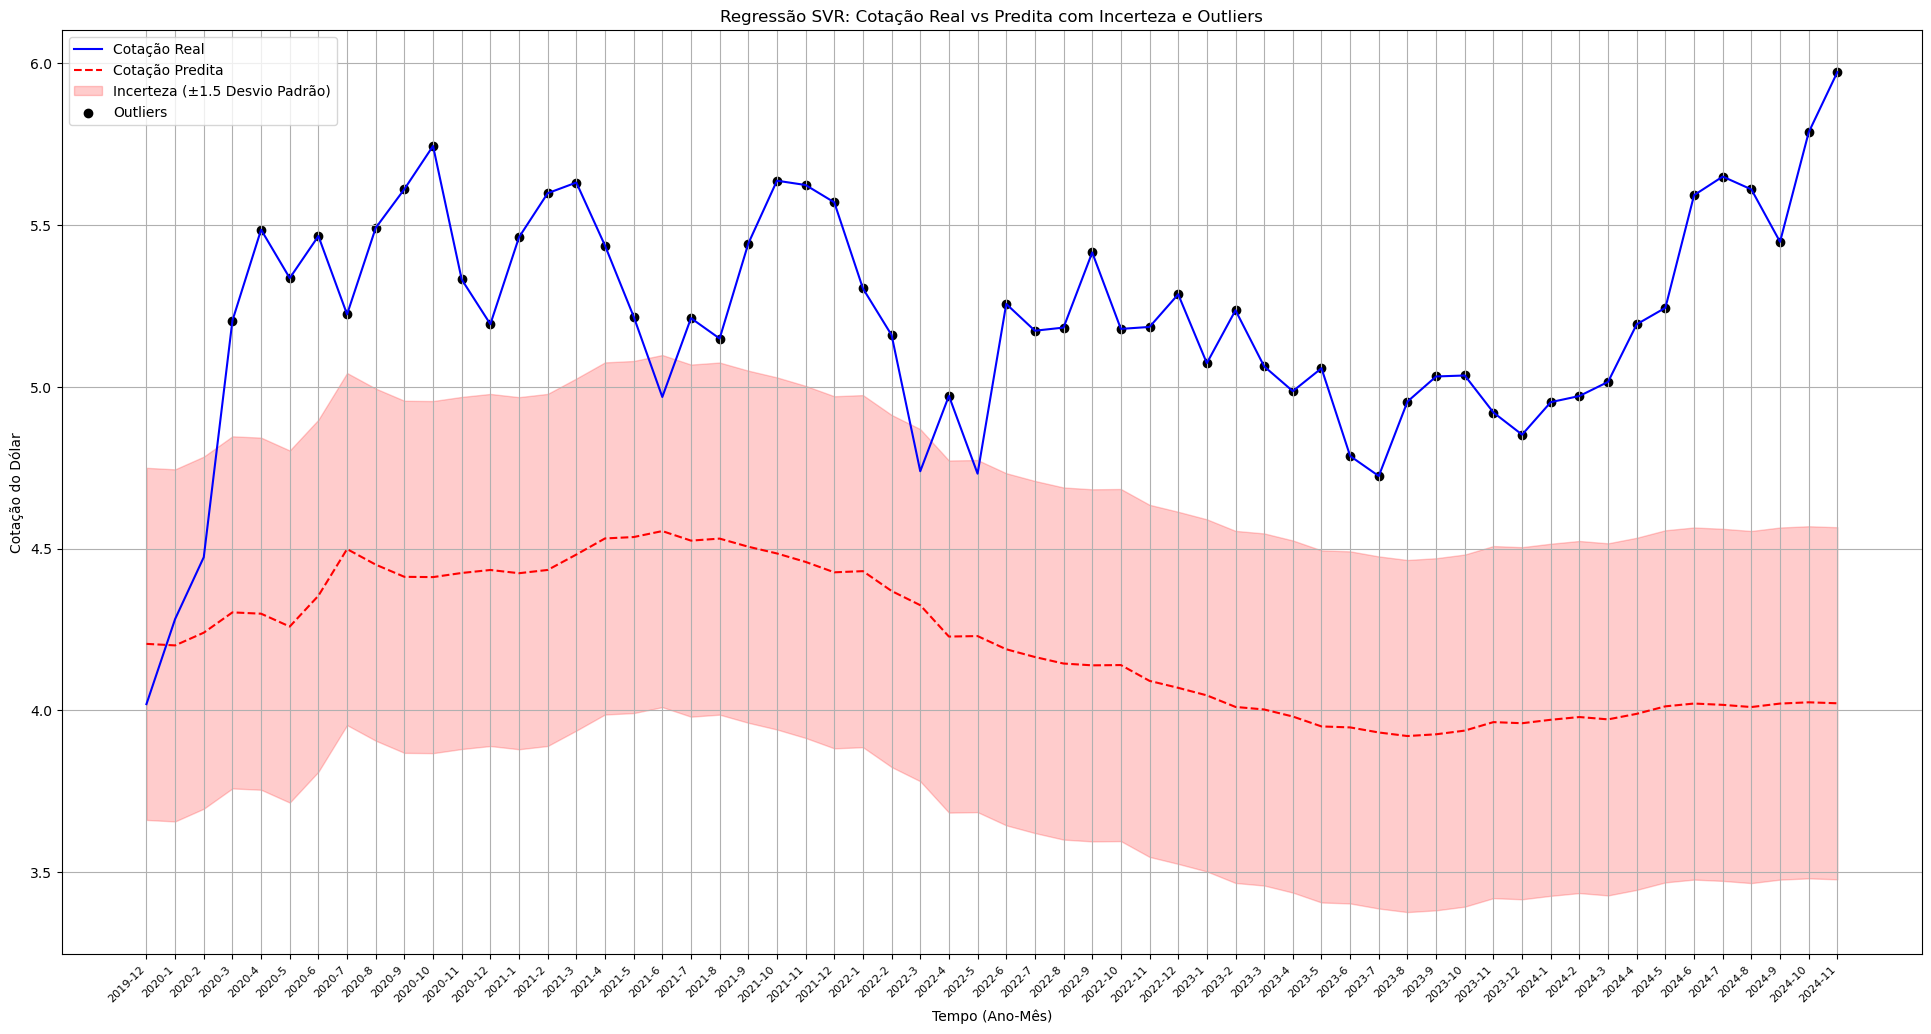

20
Melhores hiperparâmetros: OrderedDict({'C': 2.3000488006699156, 'epsilon': 0.0755197356421131, 'gamma': 0.13456846230618189, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.5557916109387286
R² score: -1.9670658704156008


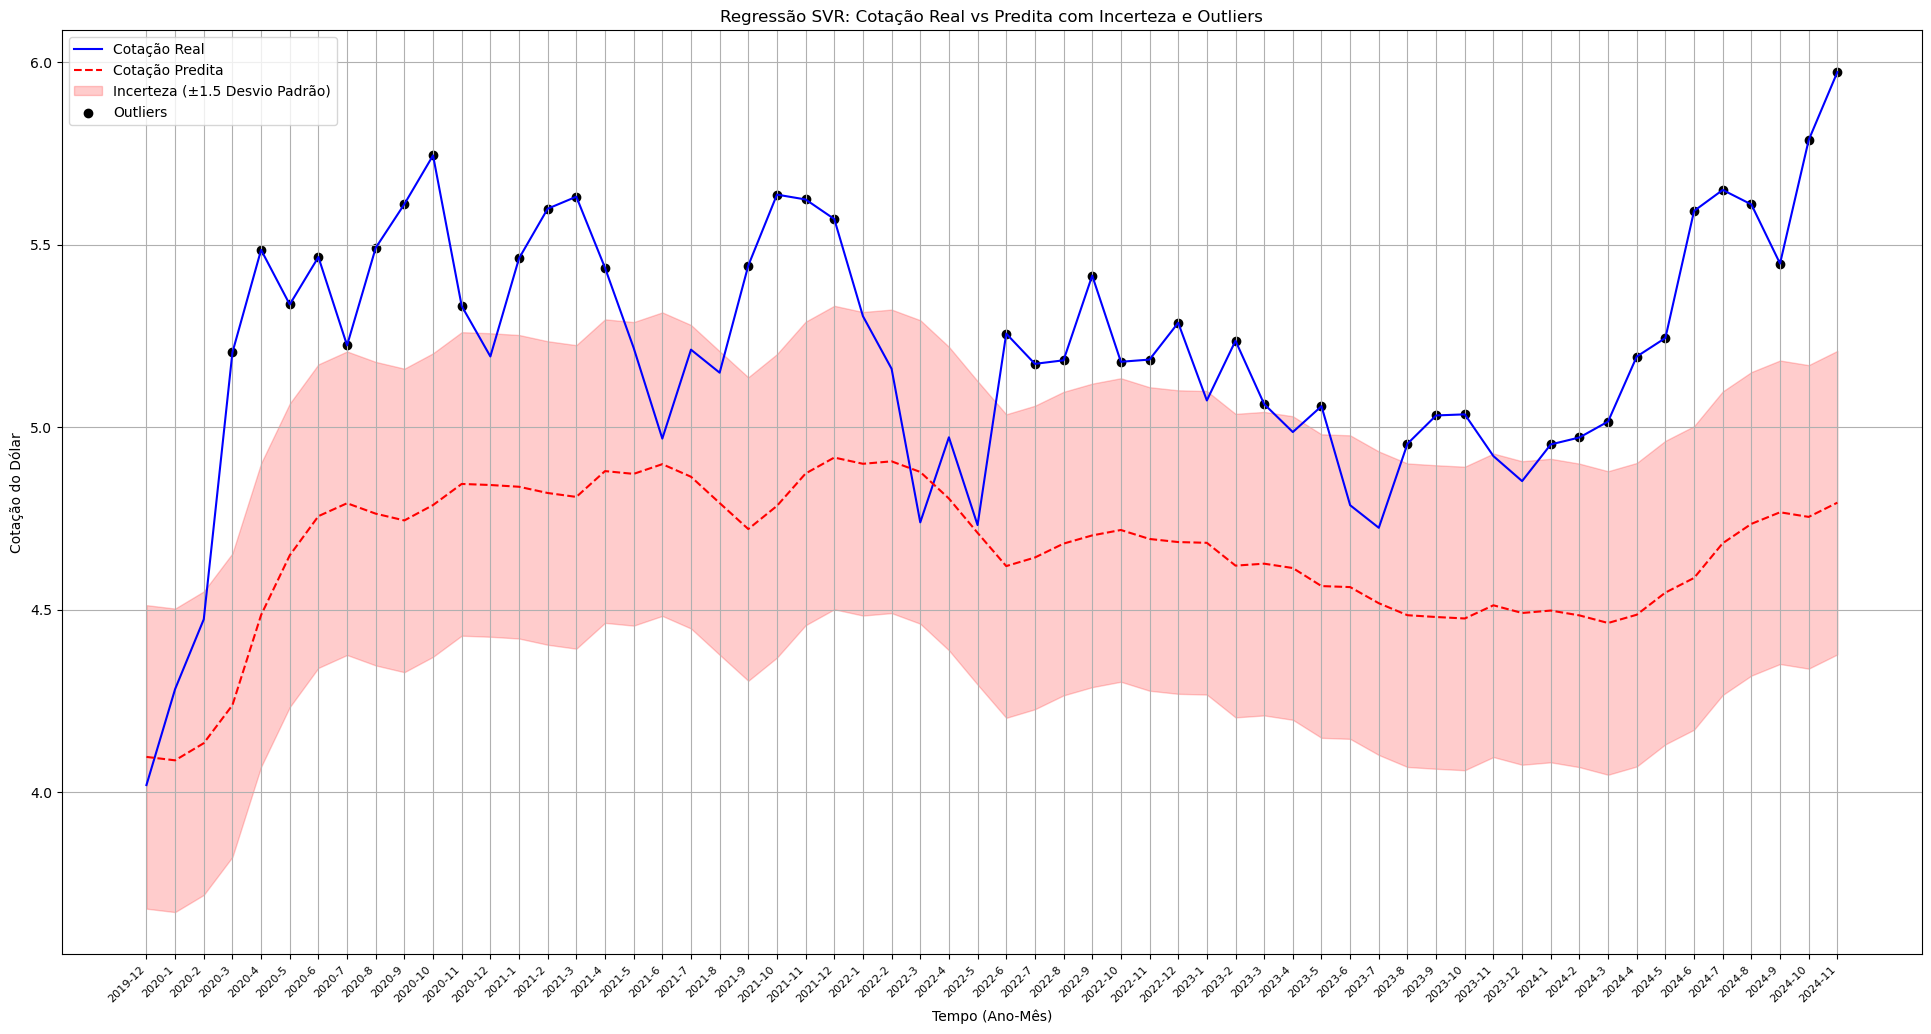

30
Melhores hiperparâmetros: OrderedDict({'C': 3.22779363799014, 'epsilon': 0.06859639148562437, 'gamma': 0.15219893804095222, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.5762101440040355
R² score: -2.177666811966847


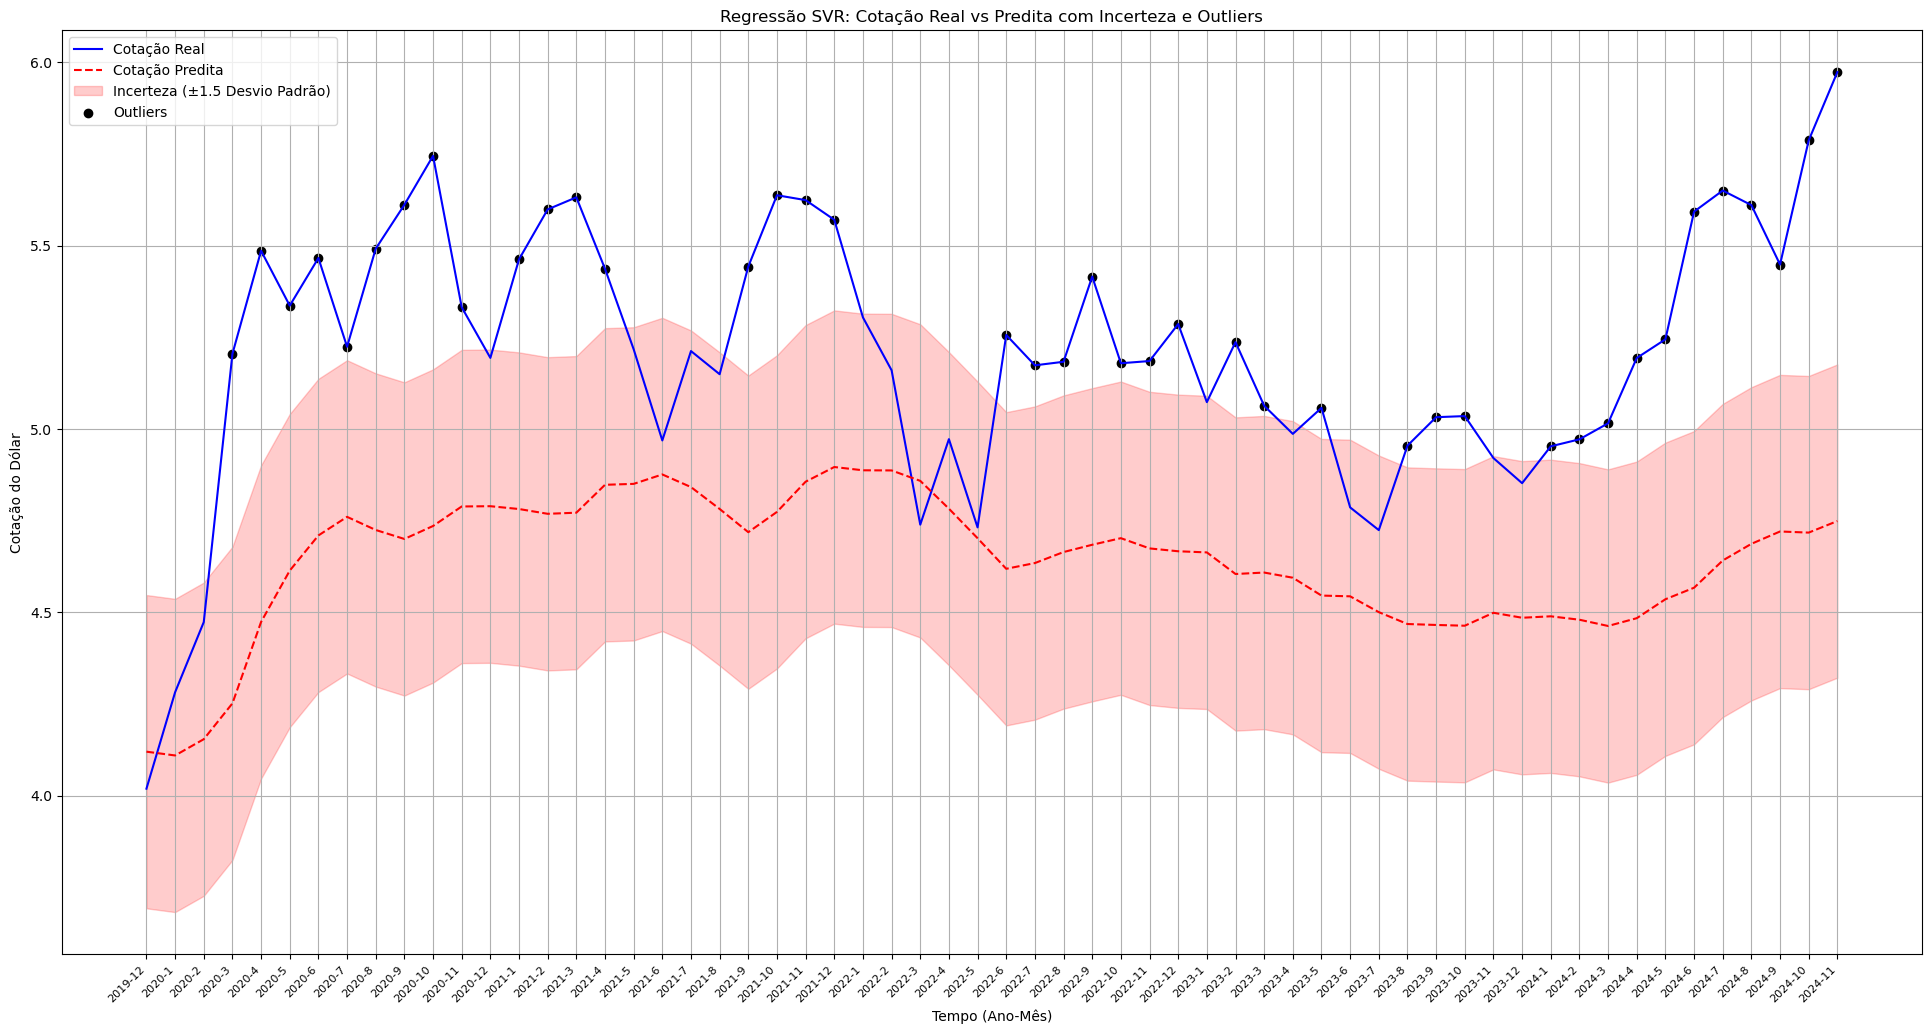

40
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.0001, 'gamma': 0.002389100299962989, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.2799124978132757
R² score: -0.03839472074398631


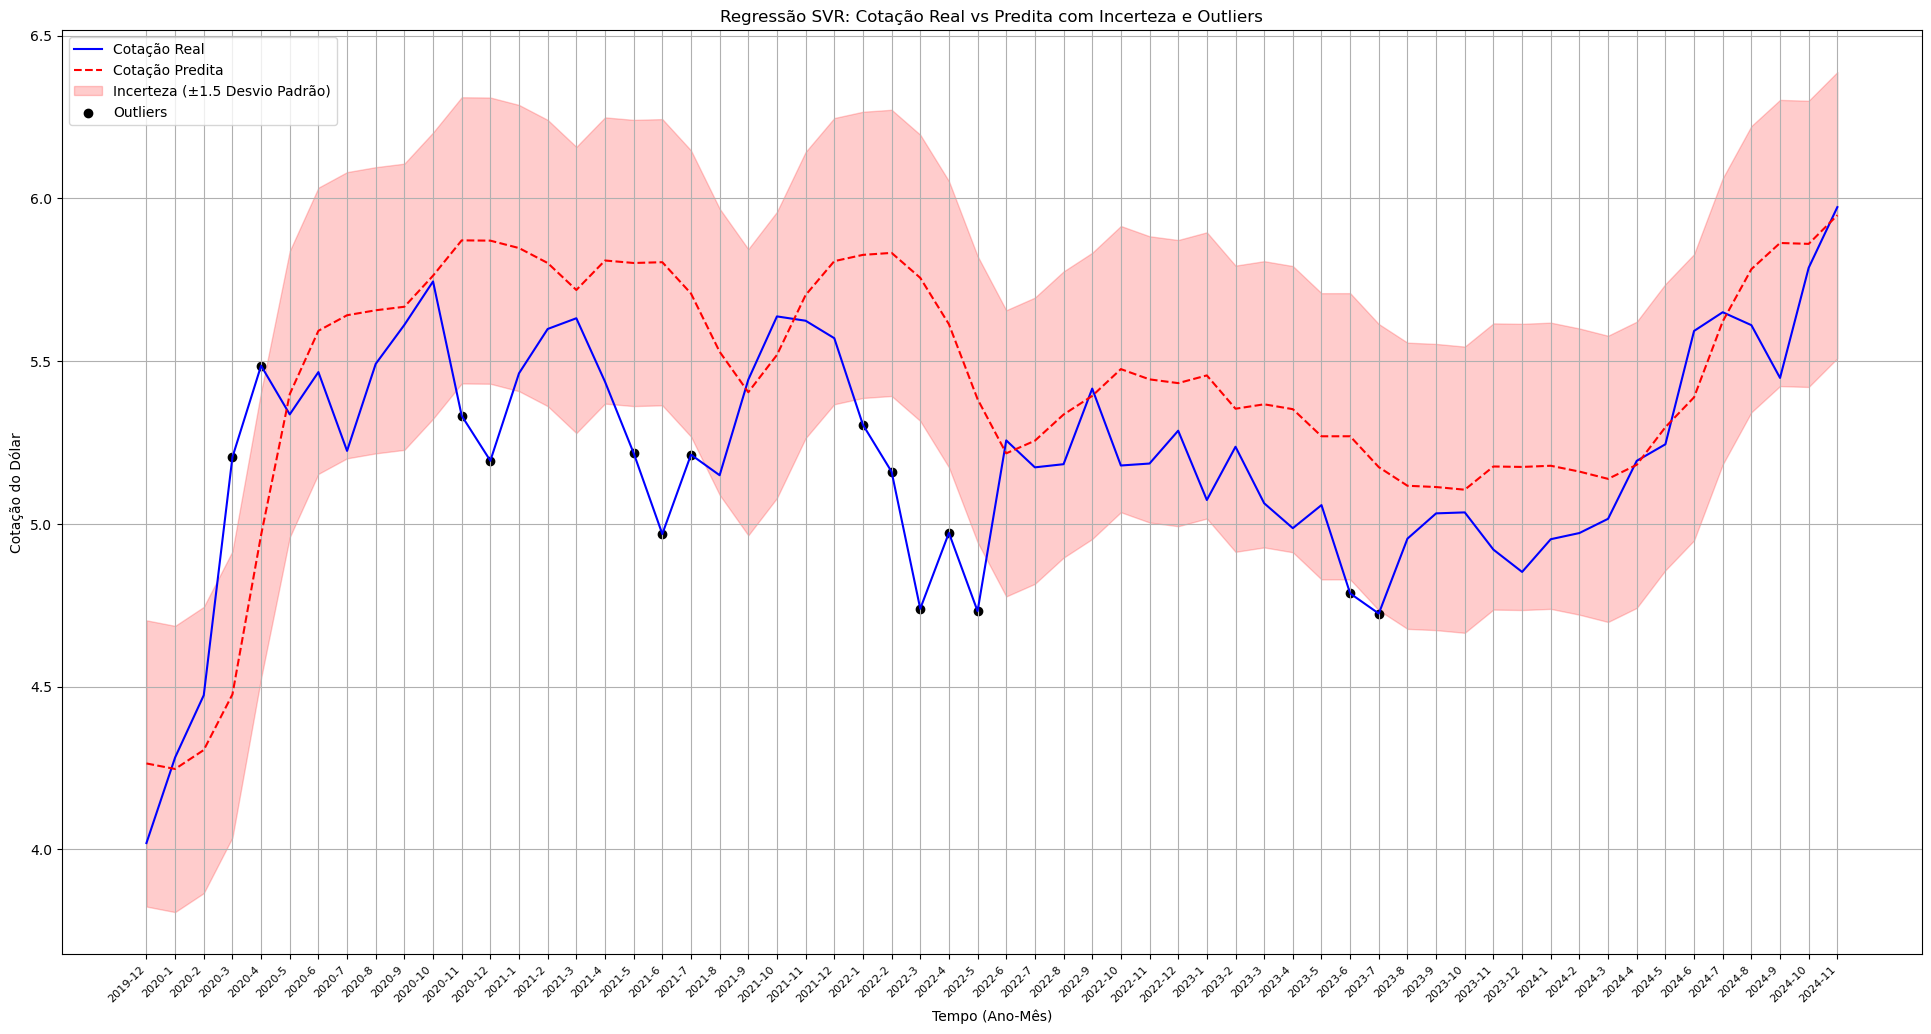

50
Melhores hiperparâmetros: OrderedDict({'C': 231.8685606393786, 'epsilon': 0.0001587747157796683, 'gamma': 0.008710768846548233, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.22294507433467117
R² score: 0.26330975347434527


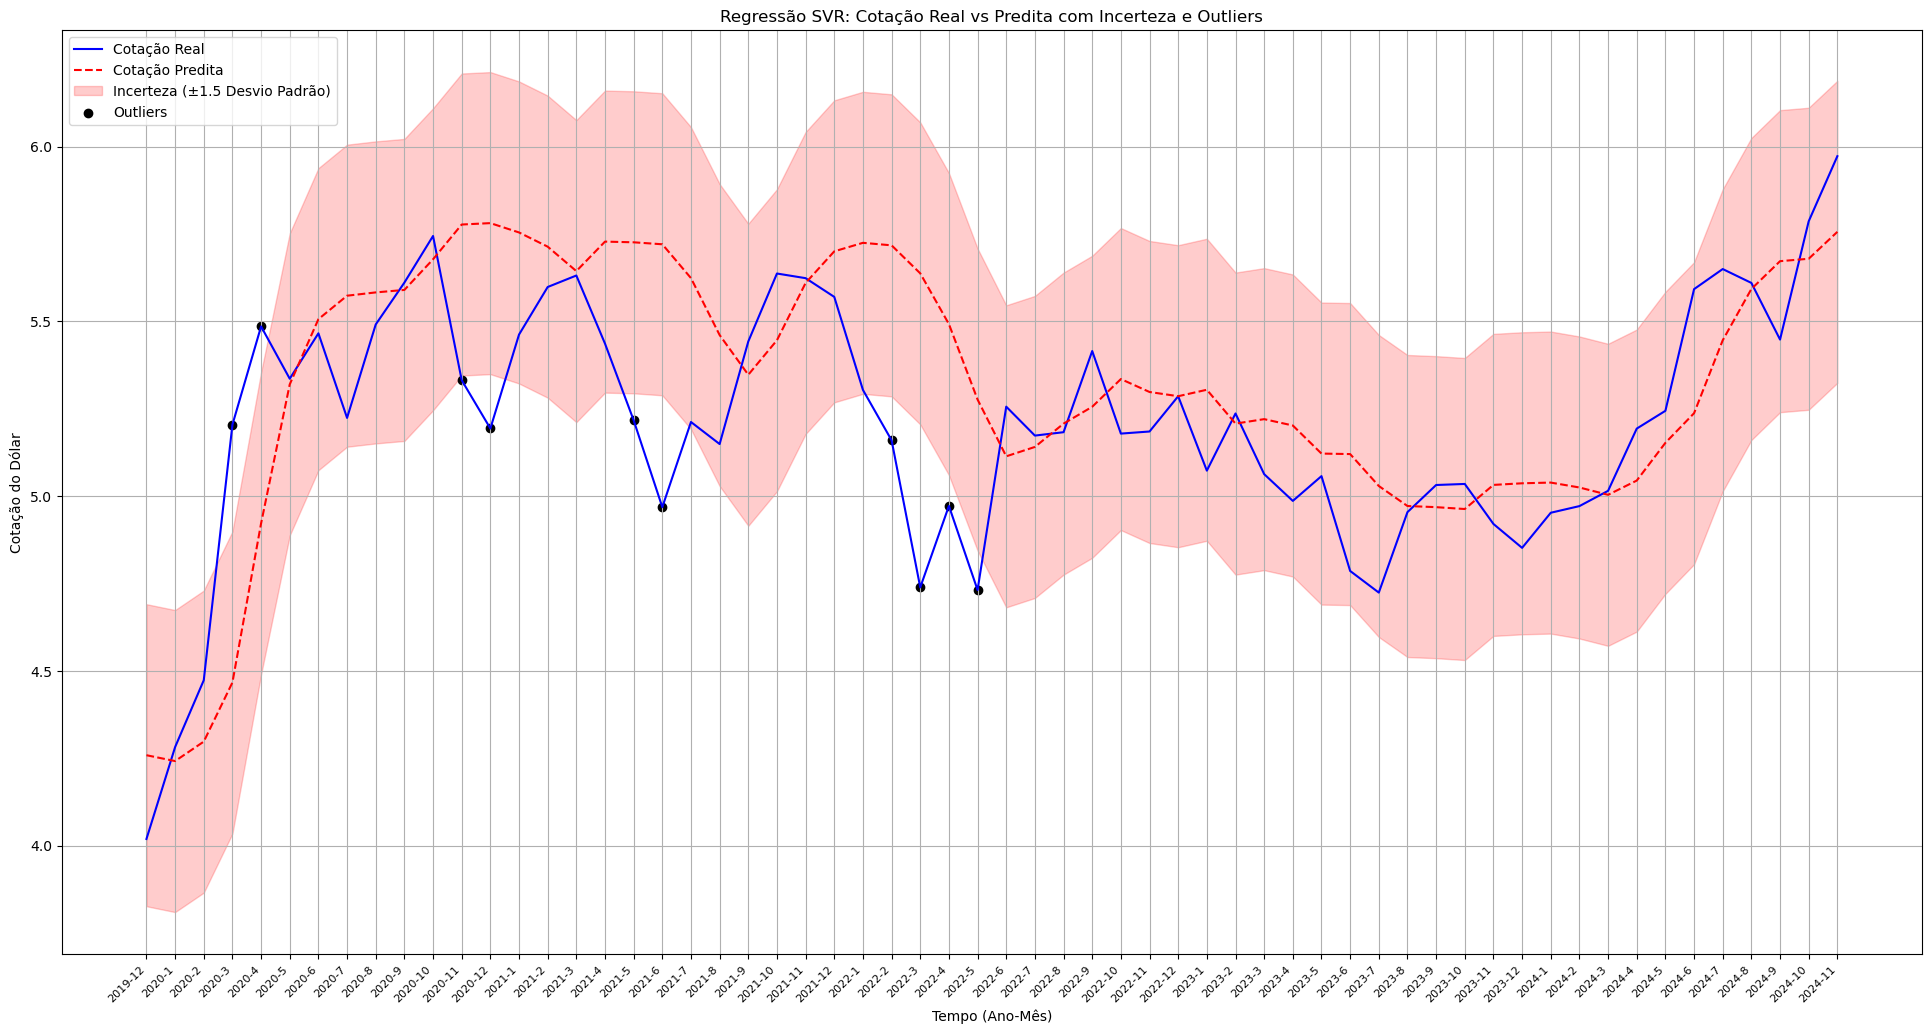

60
Melhores hiperparâmetros: OrderedDict({'C': 231.8685606393786, 'epsilon': 0.0001587747157796683, 'gamma': 0.008710768846548233, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.22294507433467117
R² score: 0.26330975347434527


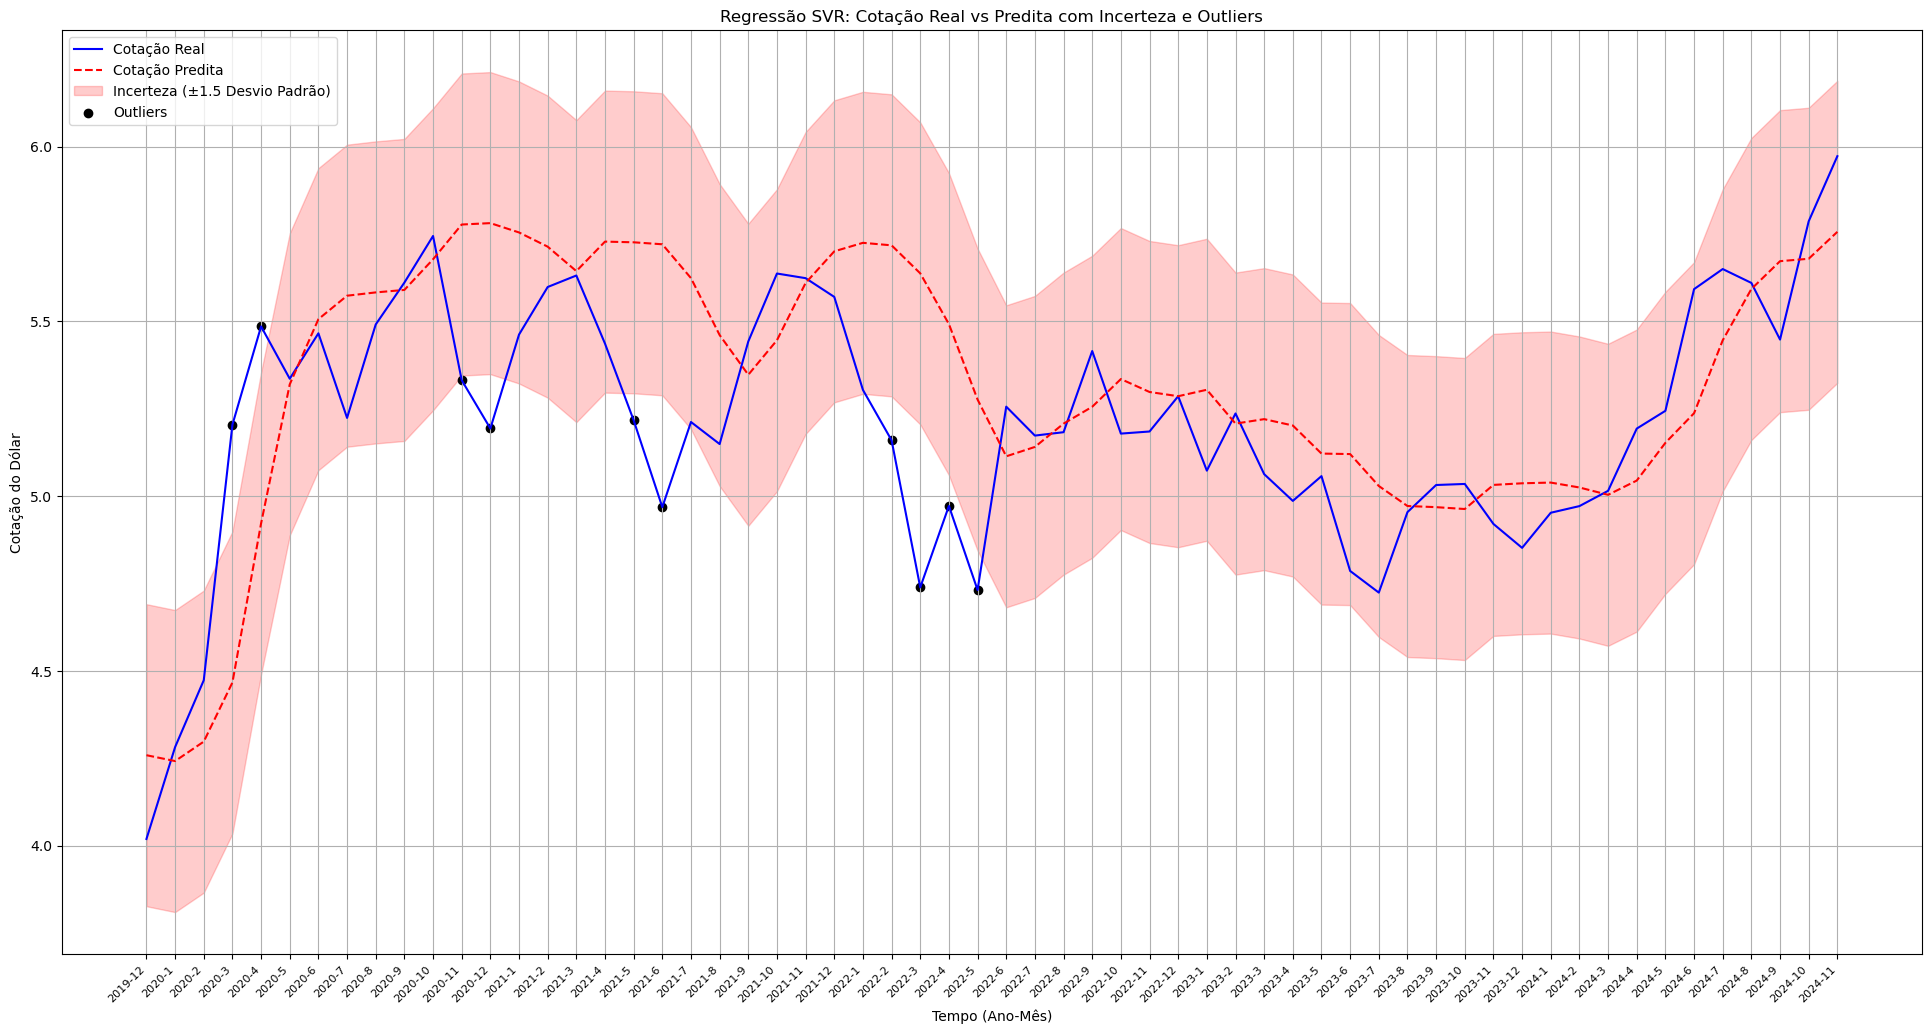

70
Melhores hiperparâmetros: OrderedDict({'C': 231.8685606393786, 'epsilon': 0.0001587747157796683, 'gamma': 0.008710768846548233, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.22294507433467117
R² score: 0.26330975347434527


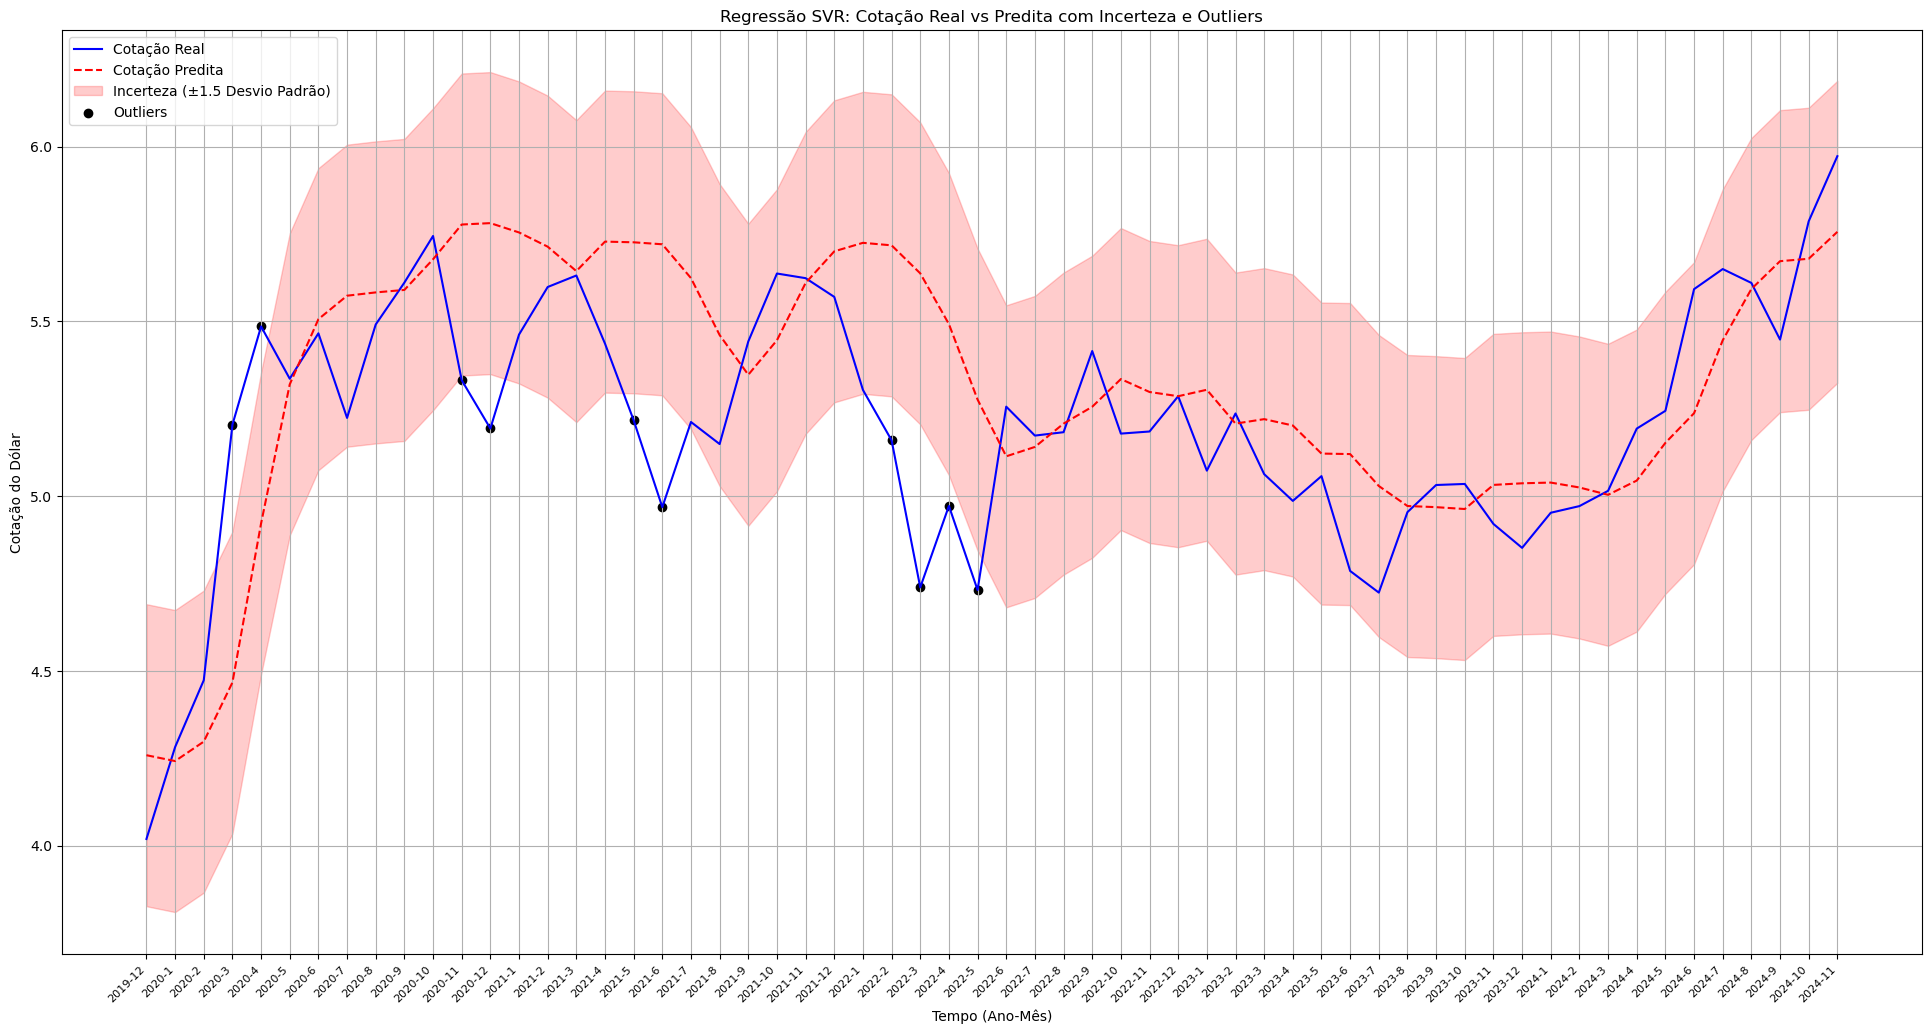

80
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.018915952623993978, 'gamma': 0.0018132095359232742, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.2409991402969093
R² score: 0.1697678933380775


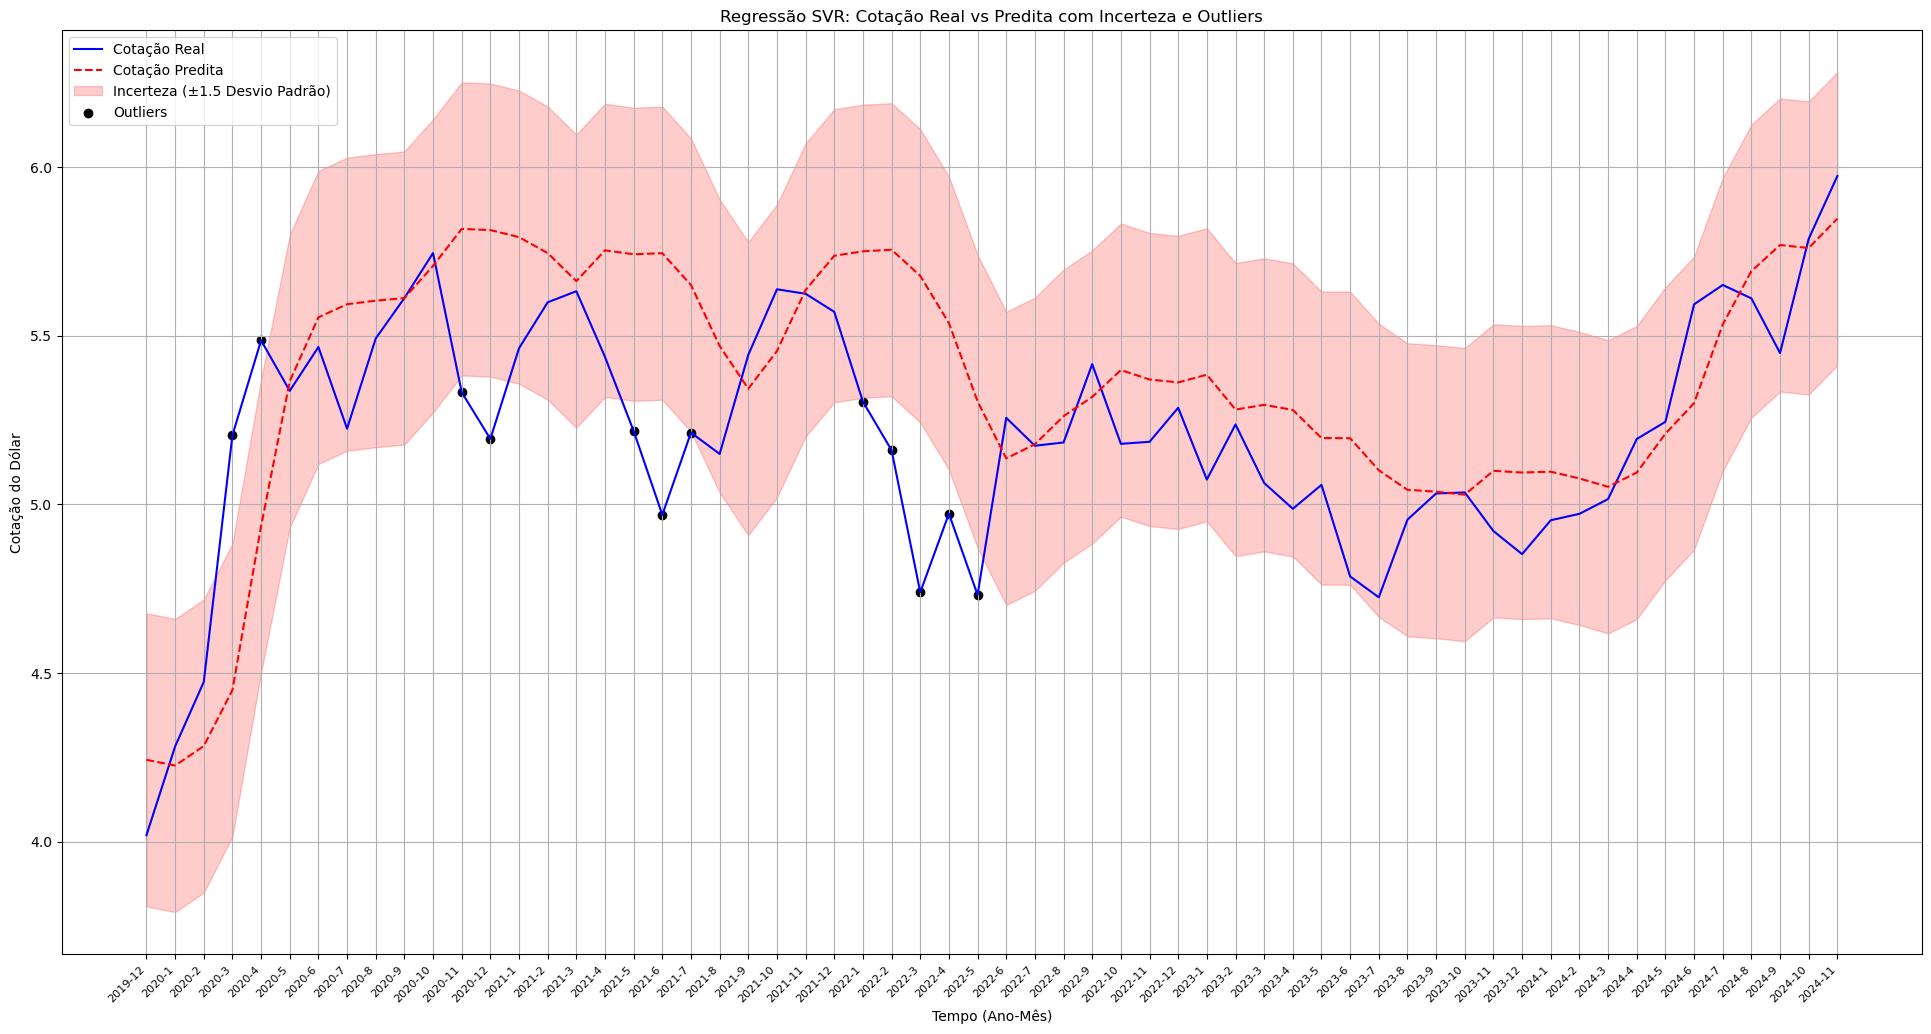

90


KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]

# Criar novas features (médias móveis e desvio padrão)
df['cotacao_mean'] = df['cotacao'].shift(1).rolling(window=4, min_periods=1).mean()
df.fillna(df['cotacao'].values[0], inplace=True)  # Lidar com NaNs no início

df['cotacao_std'] = df['cotacao'].shift(1).rolling(window=4, min_periods=1).std()
df.fillna(0, inplace=True)  # Lidar com NaNs no início

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']

for i in range(10,110,10):
    #print(i+1,(i+1)*10)
    print(i)
    # Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
    train_size = int(len(df) * 0.80)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Normalizar os dados com MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Definir o modelo SVR
    svr = SVR()
    
    # Definir os hiperparâmetros a serem otimizados
    param_grid = {
        'C': (0.1, 1000.0, 'log-uniform'),
        'epsilon': (0.0001, 1.0, 'log-uniform'),
        'gamma': (1e-5, 1.0, 'log-uniform'),
        'kernel': ['rbf', 'poly'] 
    }
    
    # Validação cruzada preservando ordem temporal
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Otimização Bayesiana com TimeSeriesSplit e métrica R²
    bayes_search = BayesSearchCV(
        svr,
        param_grid,
        n_iter=i,  # Número de avaliações, 70
        cv=tscv,  # Mantém a sequência temporal
        scoring='neg_mean_absolute_error',  # Maximizar R²
        n_jobs=-1,
        random_state=42,
        optimizer_kwargs = {'base_estimator': 'GP'}
    )
    
    # Treinar o modelo
    bayes_search.fit(X_train_scaled, y_train)
    
    # Exibir melhores hiperparâmetros
    print("Melhores hiperparâmetros:", bayes_search.best_params_)
    
    # Avaliar no conjunto de teste
    best_svr = bayes_search.best_estimator_
    y_pred = best_svr.predict(X_test_scaled)
    
    # Calcular erro médio absoluto e R²
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Erro Médio Absoluto no Teste:", mae)
    print("R² score:", r2)
    
    # Calcular os resíduos (erro)
    residuos = y_test - y_pred
    
    # Calcular o desvio padrão dos resíduos
    std_dev = np.std(residuos)
    
    mul_std = 1.5
    # Identificar pontos que estão fora da faixa de incerteza
    lower_bound = y_pred - mul_std * std_dev
    upper_bound = y_pred + mul_std * std_dev
    outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)
    
    # Criar rótulos do eixo X (ano-mês) para o conjunto de teste
    x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values
    
    # Criar gráfico de predição vs. real
    plt.figure(figsize=(24, 12))
    plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
    plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")
    
    # Adicionar faixa de incerteza
    plt.fill_between(x_labels, lower_bound, upper_bound, 
                     color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")
    
    # Plotar os outliers como pontos destacados
    plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
                color='black', marker='o', label="Outliers")
    
    # Melhorar legibilidade do eixo X
    plt.xticks(rotation=45, ha='right', fontsize=8)
    
    # Configurações do gráfico
    plt.xlabel("Tempo (Ano-Mês)")
    plt.ylabel("Cotação do Dólar")
    plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
    plt.legend()
    plt.grid()
    plt.show()


10
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.7873376193643203
R² score: -4.6396151441452185


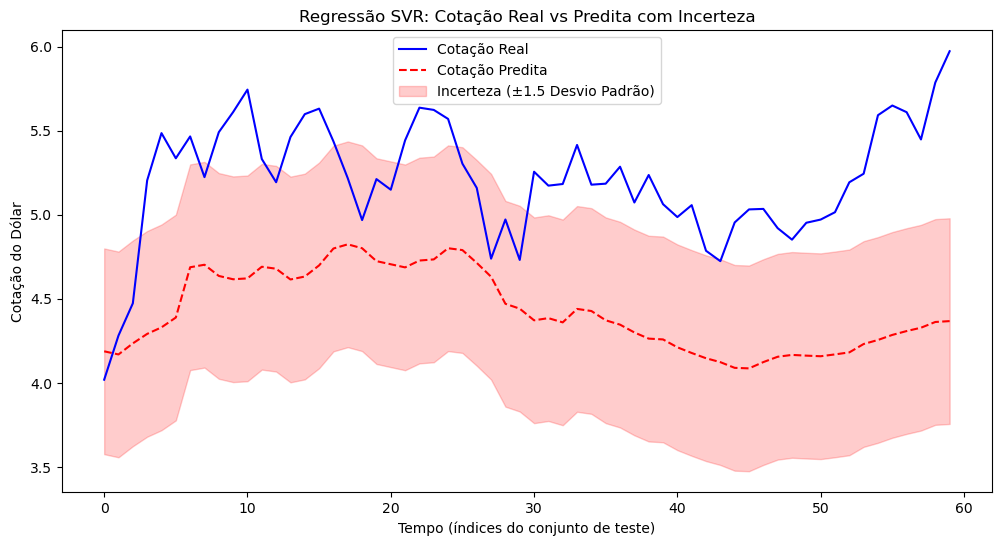

20
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.7873376193643203
R² score: -4.6396151441452185


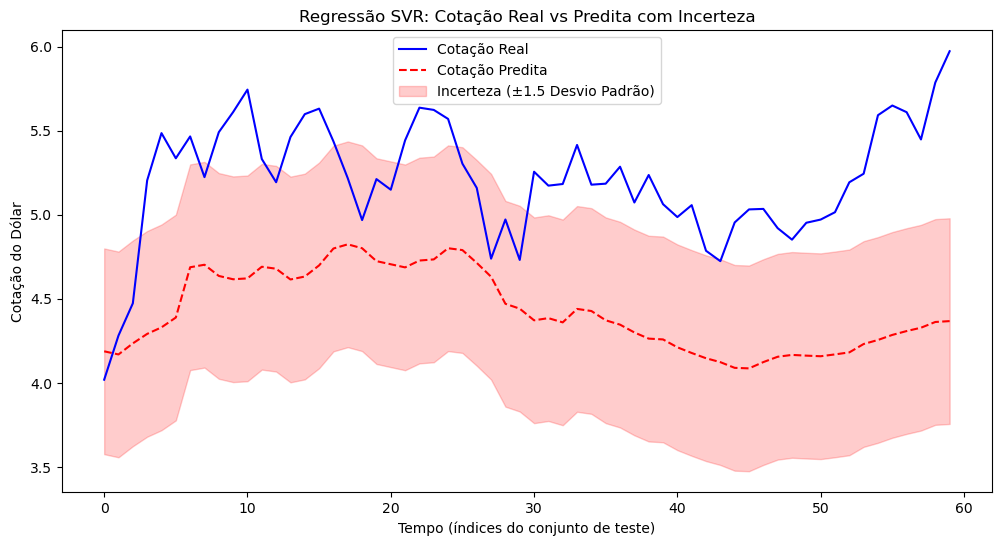

30
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.7873376193643203
R² score: -4.6396151441452185


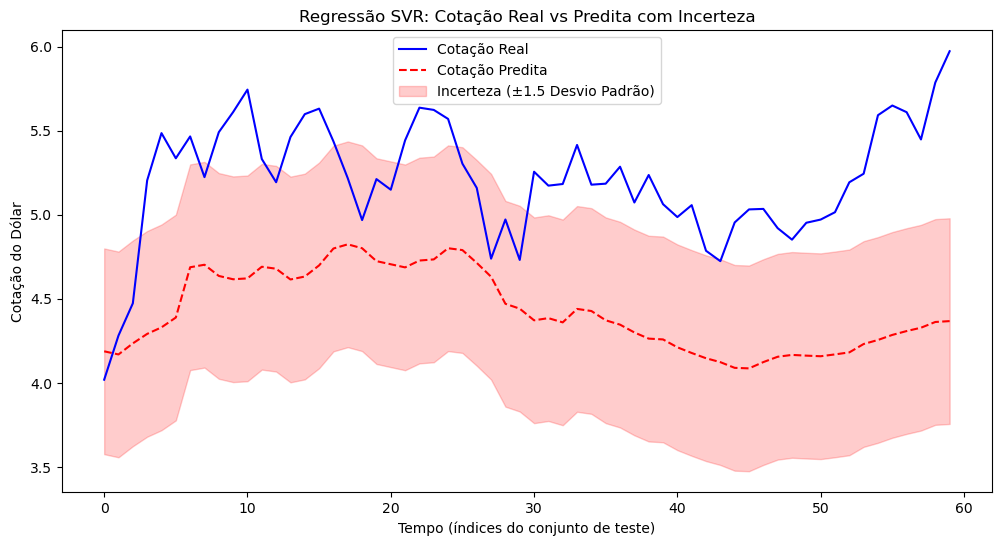

40
Melhores hiperparâmetros: OrderedDict({'C': 31.55442231409933, 'epsilon': 0.00021438175147145655, 'gamma': 0.11576793870469068, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.2398163810335479
R² score: 0.27204799327870754


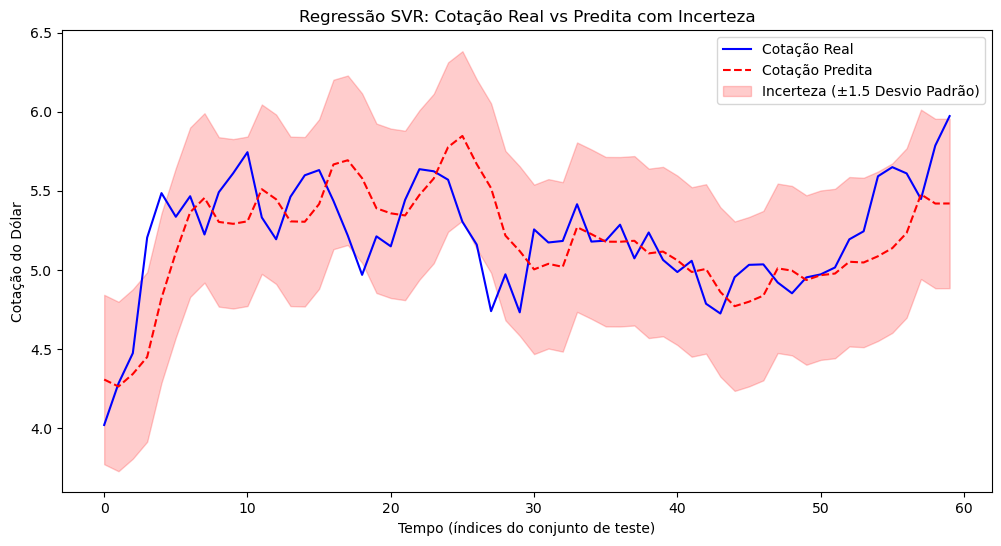

50
Melhores hiperparâmetros: OrderedDict({'C': 31.55442231409933, 'epsilon': 0.00021438175147145655, 'gamma': 0.11576793870469068, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.2398163810335479
R² score: 0.27204799327870754


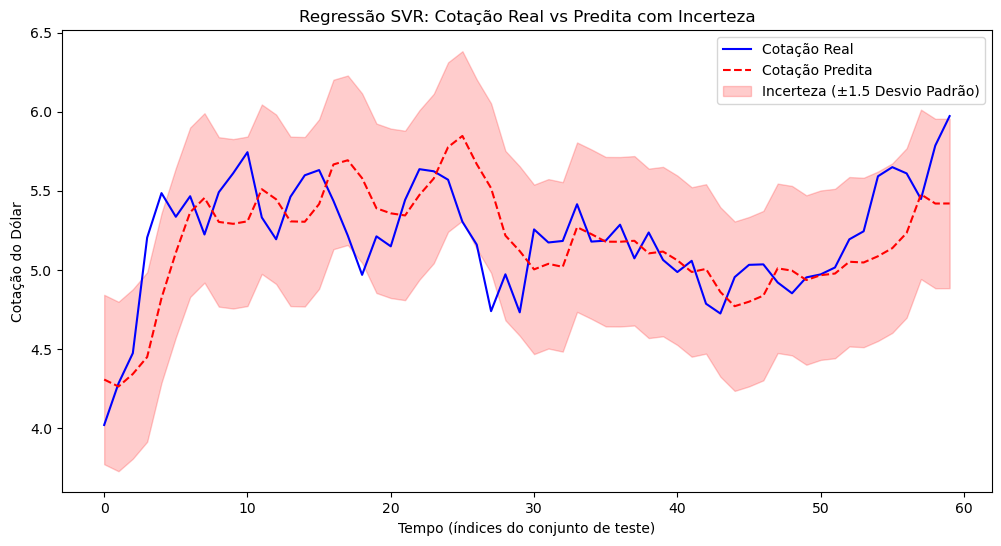

60
Melhores hiperparâmetros: OrderedDict({'C': 31.55442231409933, 'epsilon': 0.00021438175147145655, 'gamma': 0.11576793870469068, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.2398163810335479
R² score: 0.27204799327870754


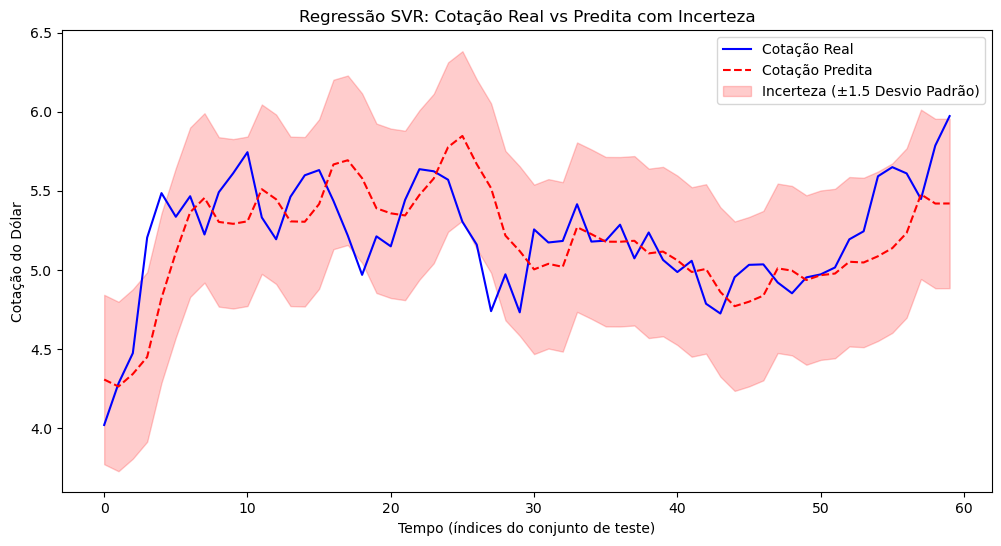

70
Melhores hiperparâmetros: OrderedDict({'C': 31.55442231409933, 'epsilon': 0.00021438175147145655, 'gamma': 0.11576793870469068, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.2398163810335479
R² score: 0.27204799327870754


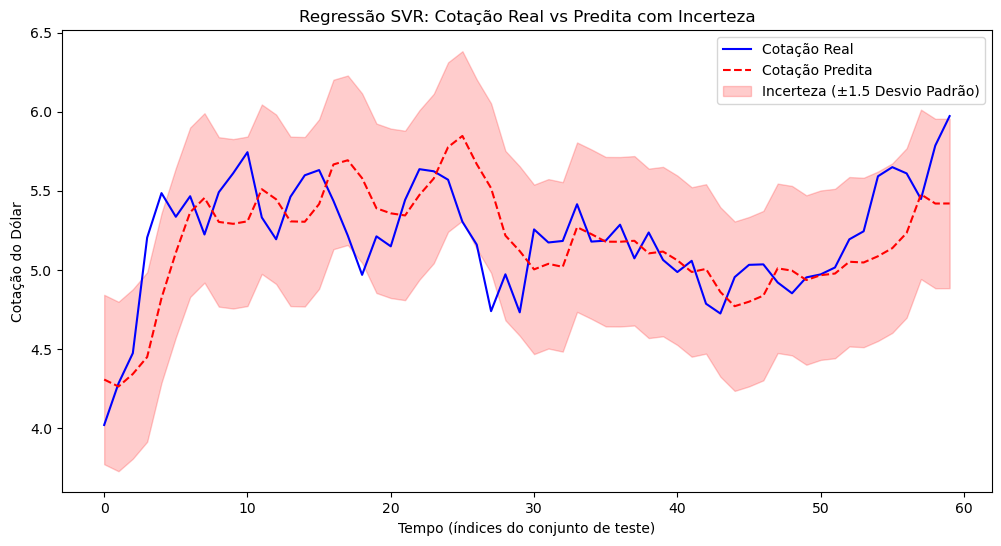

80
Melhores hiperparâmetros: OrderedDict({'C': 31.55442231409933, 'epsilon': 0.00021438175147145655, 'gamma': 0.11576793870469068, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.2398163810335479
R² score: 0.27204799327870754


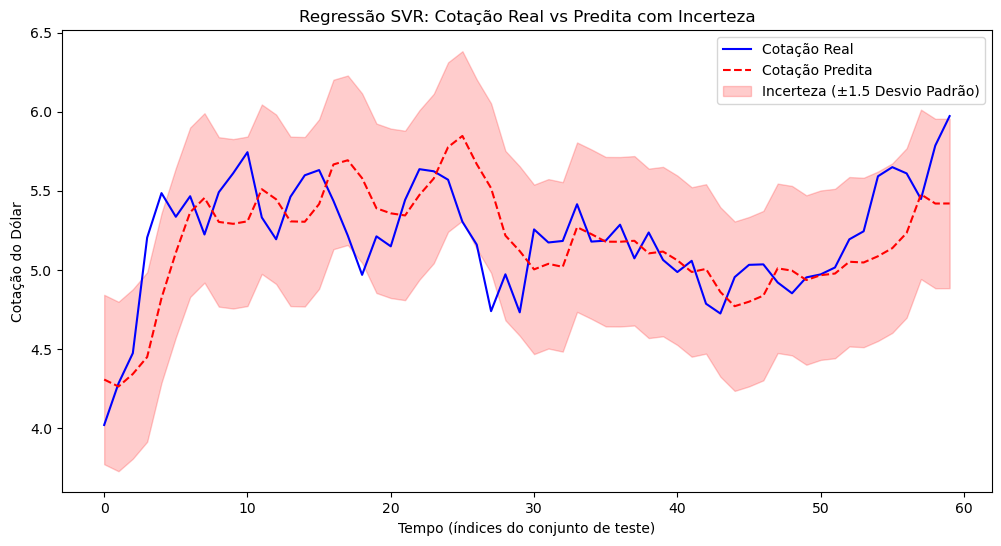

90
Melhores hiperparâmetros: OrderedDict({'C': 23.323557644393595, 'epsilon': 0.0002673205099631511, 'gamma': 0.166558575386842, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.271047129560875
R² score: 0.0763771638724623


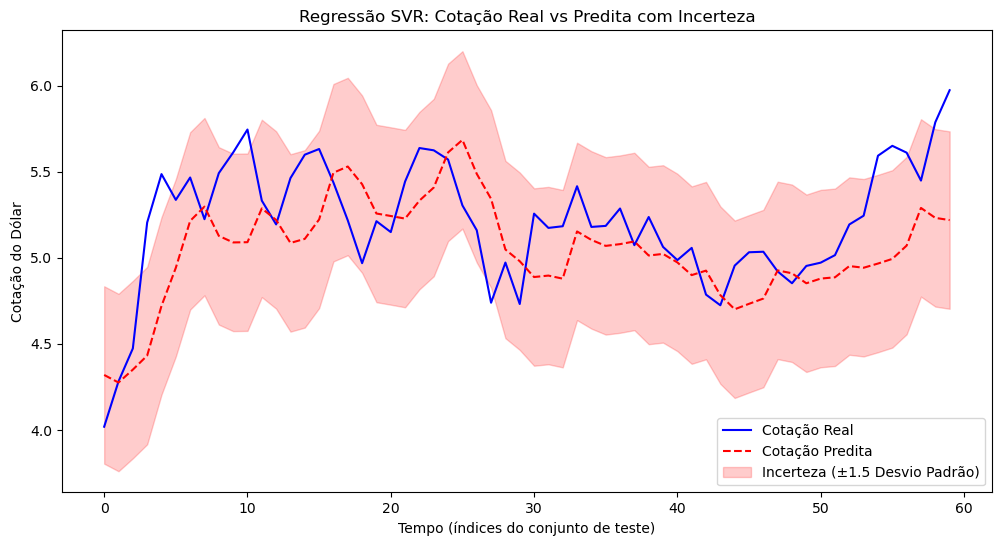

100
Melhores hiperparâmetros: OrderedDict({'C': 23.323557644393595, 'epsilon': 0.0002673205099631511, 'gamma': 0.166558575386842, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.271047129560875
R² score: 0.0763771638724623


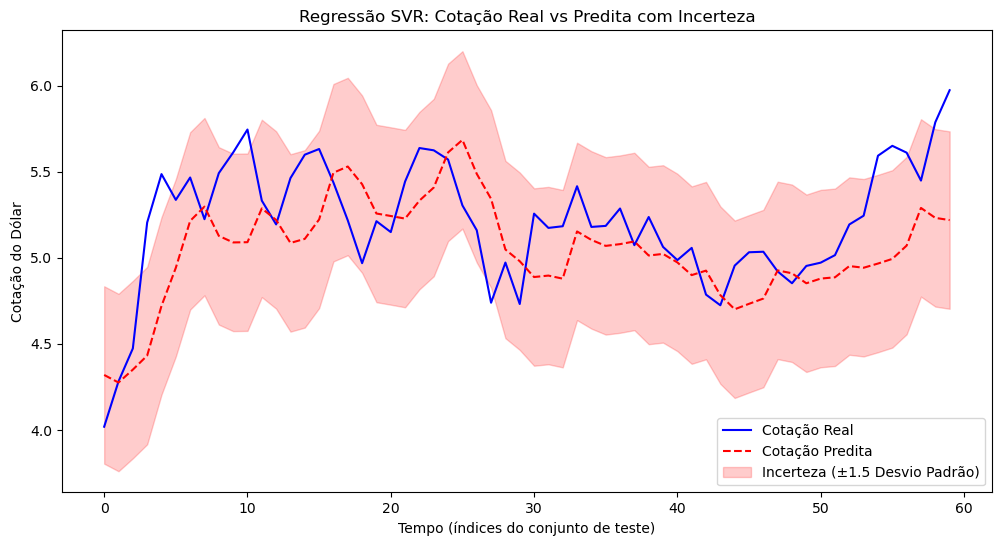

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]
# Criar novas features (médias móveis e desvio padrão)
df['rolling_mean'] = df['cotacao'].shift(1).rolling(window=3).mean()
df['rolling_std'] = df['cotacao'].shift(1).rolling(window=3).std()

df.fillna(0, inplace=True)  # Lidar com NaNs no início

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']

for i in range(10,110,10):
    #print(i+1,(i+1)*10)
    print(i)
    # Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Normalizar os dados com MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Definir o modelo SVR
    svr = SVR()
    
    # Definir os hiperparâmetros a serem otimizados
    param_grid = {
        'C': (0.1, 1000.0, 'log-uniform'),
        'epsilon': (0.0001, 1.0, 'log-uniform'),
        'gamma': (1e-5, 1.0, 'log-uniform'),
        'kernel': ['rbf', 'poly'] 
    }
    
    # Validação cruzada preservando ordem temporal
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Otimização Bayesiana com TimeSeriesSplit e métrica R²
    bayes_search = BayesSearchCV(
        svr,
        param_grid,
        n_iter=i,  # Número de avaliações, 50
        cv=tscv,  # Mantém a sequência temporal
        scoring='neg_mean_absolute_error',  
        n_jobs=-1,
        random_state=42
    )
    
    # Treinar o modelo
    bayes_search.fit(X_train_scaled, y_train)
    
    # Exibir melhores hiperparâmetros
    print("Melhores hiperparâmetros:", bayes_search.best_params_)
    
    # Avaliar no conjunto de teste
    best_svr = bayes_search.best_estimator_
    y_pred = best_svr.predict(X_test_scaled)
    
    # Calcular erro médio absoluto e R²
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Erro Médio Absoluto no Teste:", mae)
    print("R² score:", r2)
    
    # Estimativa da incerteza usando TimeSeriesSplit manualmente
    residuos = []
    for train_idx, test_idx in tscv.split(X_train_scaled):
        X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        best_svr.fit(X_fold_train, y_fold_train)  # Treinar no subconjunto
        y_fold_pred = best_svr.predict(X_fold_test)  # Fazer predição no subconjunto
        
        residuos.extend(y_fold_test - y_fold_pred)  # Armazenar os resíduos
    
    # Calcular desvio padrão dos resíduos
    std_dev = np.std(residuos)
    
    # Criar gráfico de predição vs. real
    mul_std = 1.5
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label="Cotação Real", color="blue")
    plt.plot(y_pred, label="Cotação Predita", color="red", linestyle="dashed")
    
    # Adicionar faixa de incerteza
    plt.fill_between(range(len(y_pred)), y_pred - mul_std*std_dev, y_pred + mul_std*std_dev, 
                     color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")
    
    # Configurações do gráfico
    plt.xlabel("Tempo (índices do conjunto de teste)")
    plt.ylabel("Cotação do Dólar")
    plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza")
    plt.legend()
    plt.show()


10
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.8079327663098221
R² score: -4.919136089163037


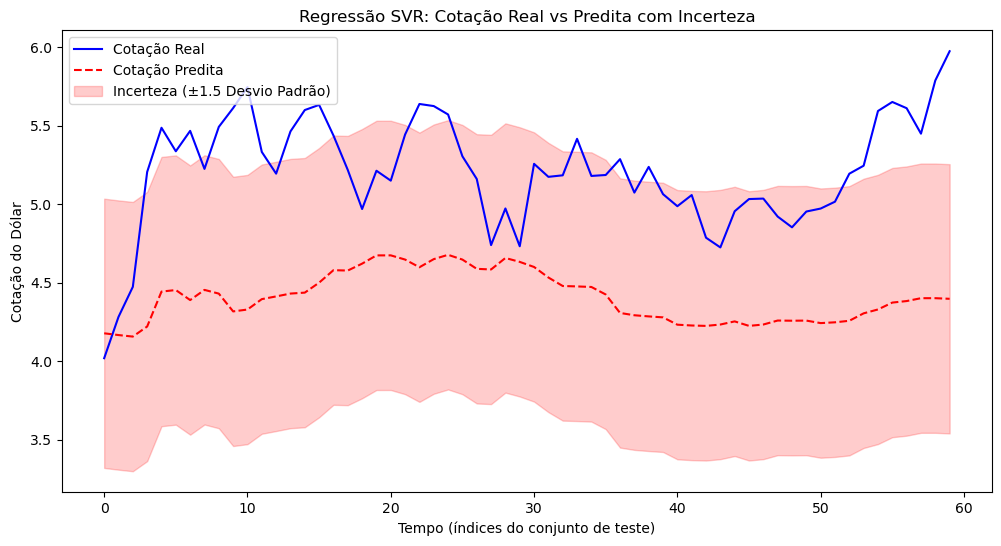

20
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.8079327663098221
R² score: -4.919136089163037


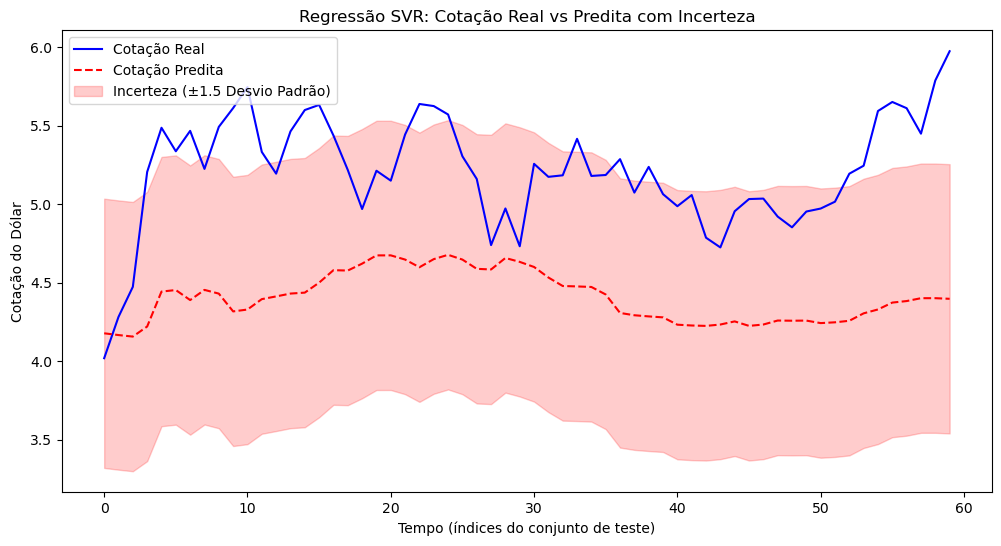

30
Melhores hiperparâmetros: OrderedDict({'C': 2.158538497389232, 'epsilon': 0.03707091808900832, 'gamma': 0.43718207347187366, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.7663512663841634
R² score: -4.386600300330322


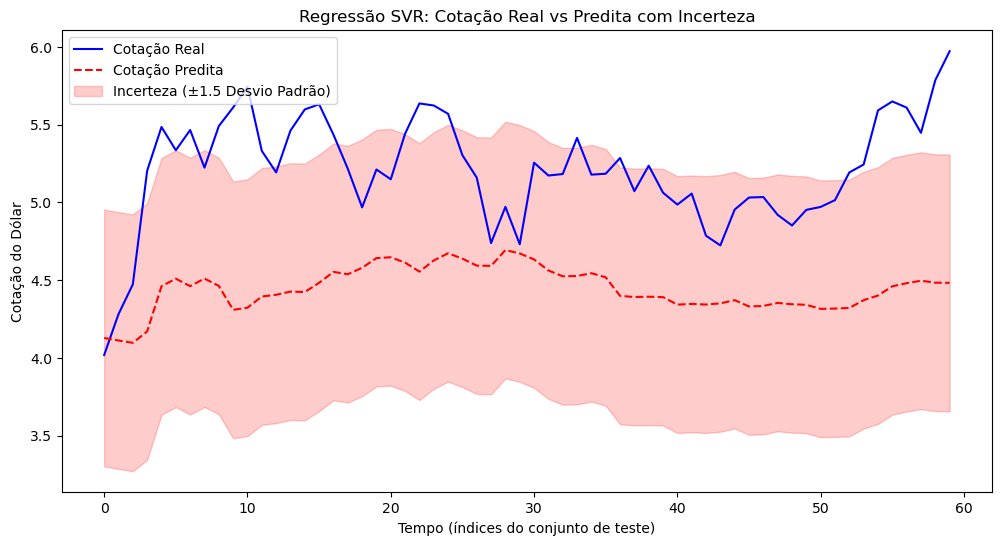

40
Melhores hiperparâmetros: OrderedDict({'C': 1.7136882593695595, 'epsilon': 0.013997560461246705, 'gamma': 0.3361505779010312, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.6352250087253724
R² score: -2.8024532963730833


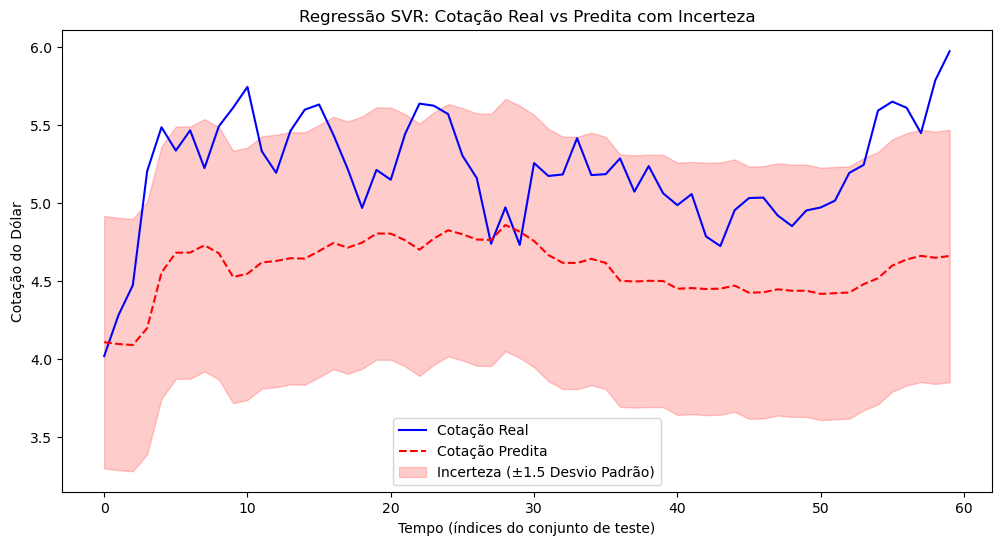

50
Melhores hiperparâmetros: OrderedDict({'C': 1.7136882593695595, 'epsilon': 0.013997560461246705, 'gamma': 0.3361505779010312, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.6352250087253724
R² score: -2.8024532963730833


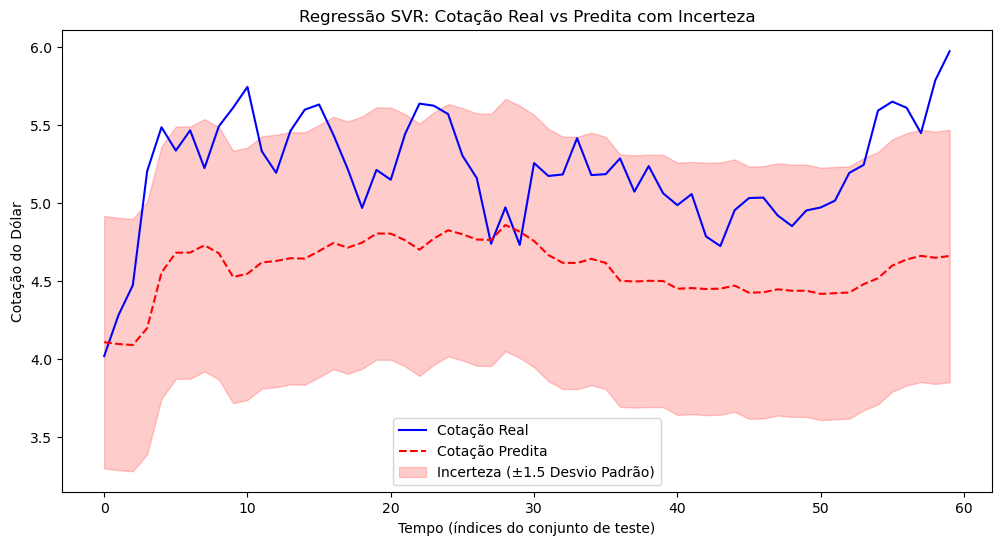

60
Melhores hiperparâmetros: OrderedDict({'C': 1.7136882593695595, 'epsilon': 0.013997560461246705, 'gamma': 0.3361505779010312, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.6352250087253724
R² score: -2.8024532963730833


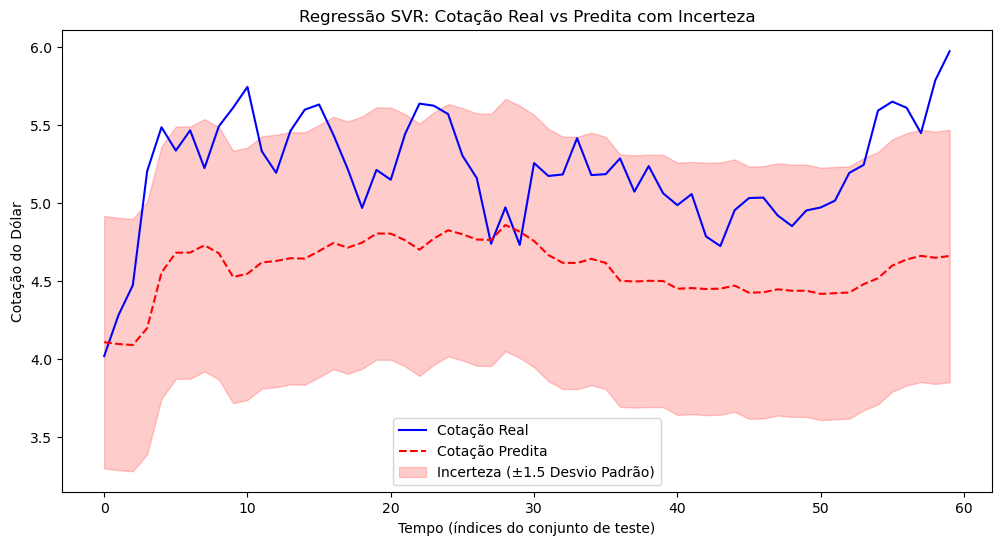

70
Melhores hiperparâmetros: OrderedDict({'C': 1.7136882593695595, 'epsilon': 0.013997560461246705, 'gamma': 0.3361505779010312, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.6352250087253724
R² score: -2.8024532963730833


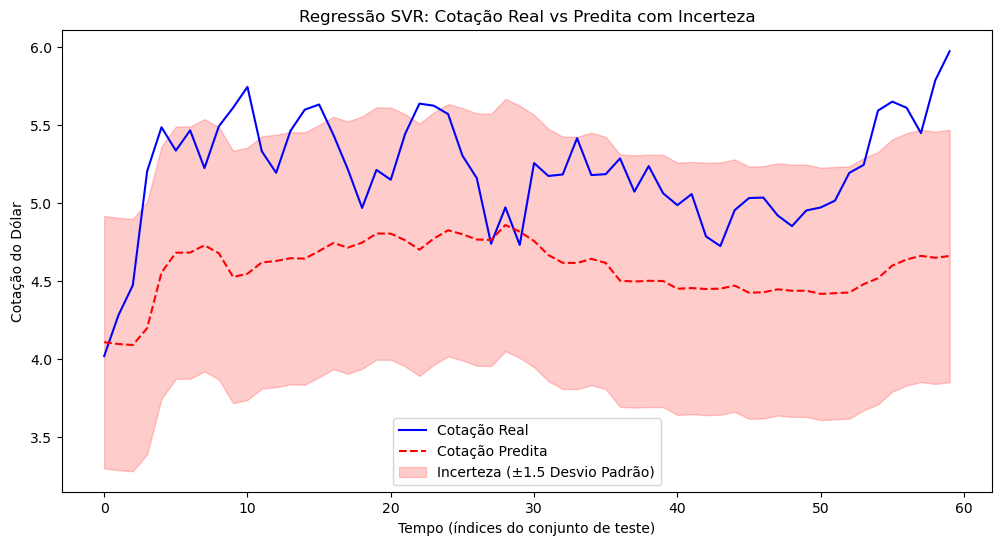

80
Melhores hiperparâmetros: OrderedDict({'C': 1.6828857685891163, 'epsilon': 0.0011533102414903245, 'gamma': 0.32356972672752177, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.6243271689380558
R² score: -2.6782289158504446


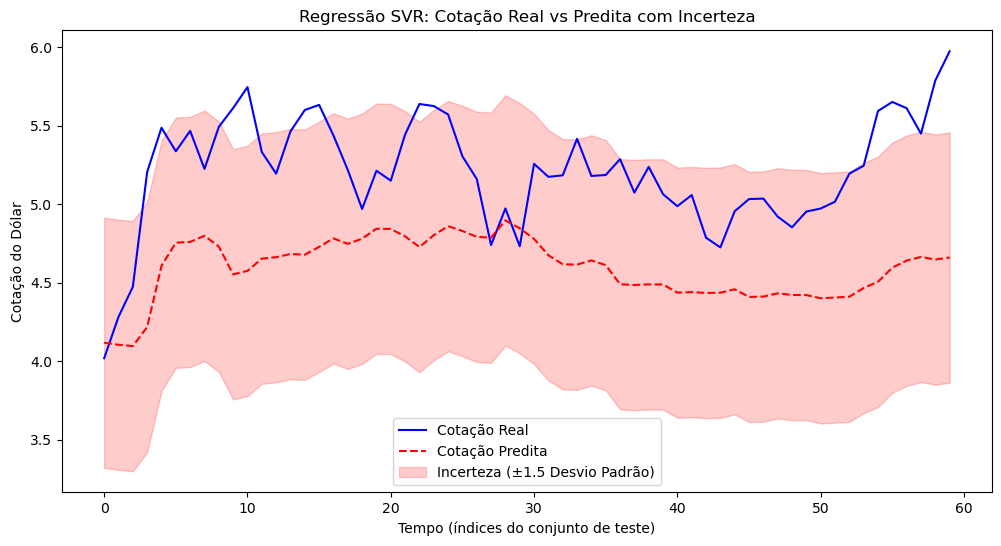

90
Melhores hiperparâmetros: OrderedDict({'C': 1.6828857685891163, 'epsilon': 0.0011533102414903245, 'gamma': 0.32356972672752177, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.6243271689380558
R² score: -2.6782289158504446


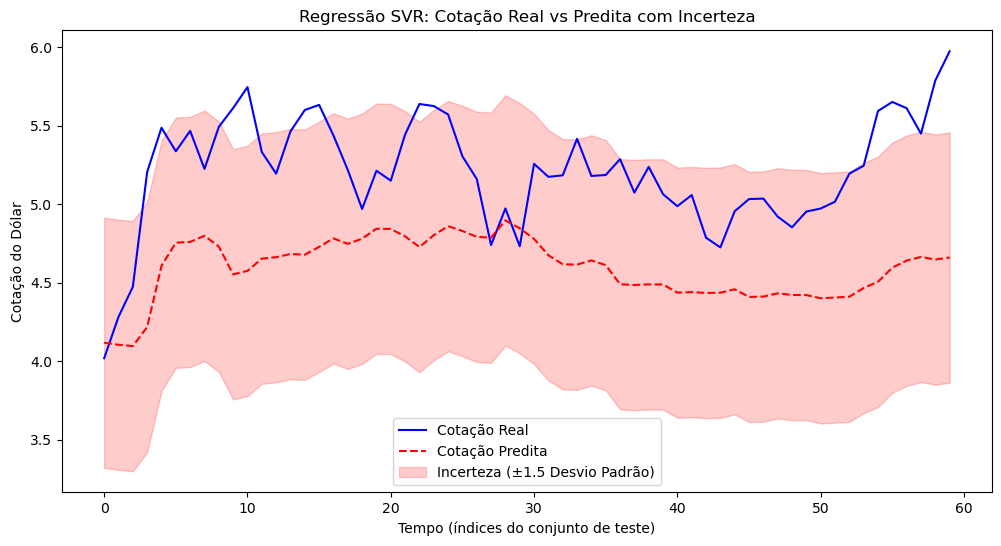

100
Melhores hiperparâmetros: OrderedDict({'C': 1.6828857685891163, 'epsilon': 0.0011533102414903245, 'gamma': 0.32356972672752177, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.6243271689380558
R² score: -2.6782289158504446


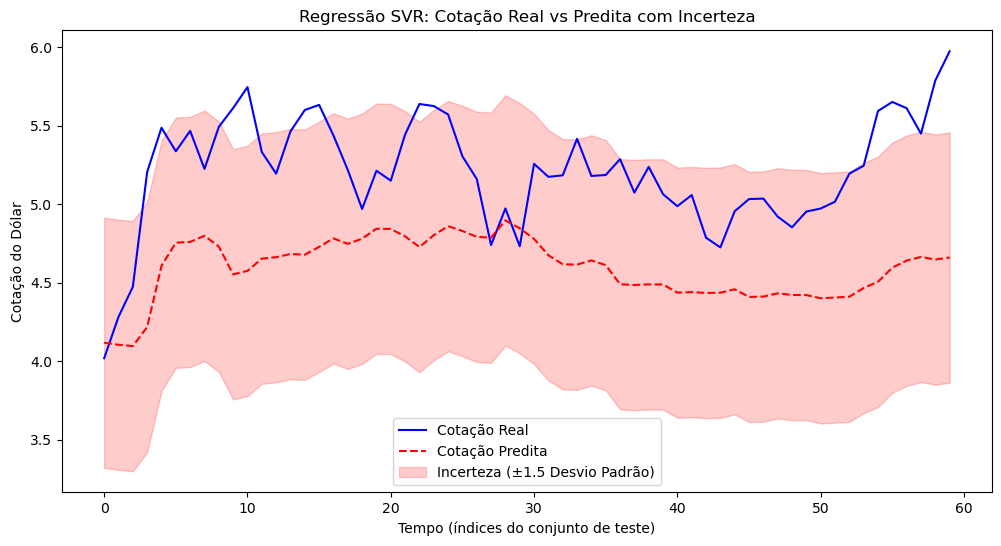

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]
# Criar novas features (médias móveis e desvio padrão)
df['rolling_mean'] = df['cotacao'].shift(1).rolling(window=6).mean()
df['rolling_std'] = df['cotacao'].shift(1).rolling(window=6).std()

df.fillna(0, inplace=True)  # Lidar com NaNs no início

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']

for i in range(10,110,10):
    #print(i+1,(i+1)*10)
    print(i)
    # Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Normalizar os dados com MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Definir o modelo SVR
    svr = SVR()
    
    # Definir os hiperparâmetros a serem otimizados
    param_grid = {
        'C': (0.1, 1000.0, 'log-uniform'),
        'epsilon': (0.0001, 1.0, 'log-uniform'),
        'gamma': (1e-5, 1.0, 'log-uniform'),
        'kernel': ['rbf', 'poly'] 
    }
    
    # Validação cruzada preservando ordem temporal
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Otimização Bayesiana com TimeSeriesSplit e métrica R²
    bayes_search = BayesSearchCV(
        svr,
        param_grid,
        n_iter=i,  # Número de avaliações, 50
        cv=tscv,  # Mantém a sequência temporal
        scoring='neg_mean_absolute_error',  
        n_jobs=-1,
        random_state=42
    )
    
    # Treinar o modelo
    bayes_search.fit(X_train_scaled, y_train)
    
    # Exibir melhores hiperparâmetros
    print("Melhores hiperparâmetros:", bayes_search.best_params_)
    
    # Avaliar no conjunto de teste
    best_svr = bayes_search.best_estimator_
    y_pred = best_svr.predict(X_test_scaled)
    
    # Calcular erro médio absoluto e R²
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Erro Médio Absoluto no Teste:", mae)
    print("R² score:", r2)
    
    # Estimativa da incerteza usando TimeSeriesSplit manualmente
    residuos = []
    for train_idx, test_idx in tscv.split(X_train_scaled):
        X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        best_svr.fit(X_fold_train, y_fold_train)  # Treinar no subconjunto
        y_fold_pred = best_svr.predict(X_fold_test)  # Fazer predição no subconjunto
        
        residuos.extend(y_fold_test - y_fold_pred)  # Armazenar os resíduos
    
    # Calcular desvio padrão dos resíduos
    std_dev = np.std(residuos)
    
    # Criar gráfico de predição vs. real
    mul_std = 1.5
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label="Cotação Real", color="blue")
    plt.plot(y_pred, label="Cotação Predita", color="red", linestyle="dashed")
    
    # Adicionar faixa de incerteza
    plt.fill_between(range(len(y_pred)), y_pred - mul_std*std_dev, y_pred + mul_std*std_dev, 
                     color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")
    
    # Configurações do gráfico
    plt.xlabel("Tempo (índices do conjunto de teste)")
    plt.ylabel("Cotação do Dólar")
    plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza")
    plt.legend()
    plt.show()


10
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.7256281325729188
R² score: -3.7941806957212485


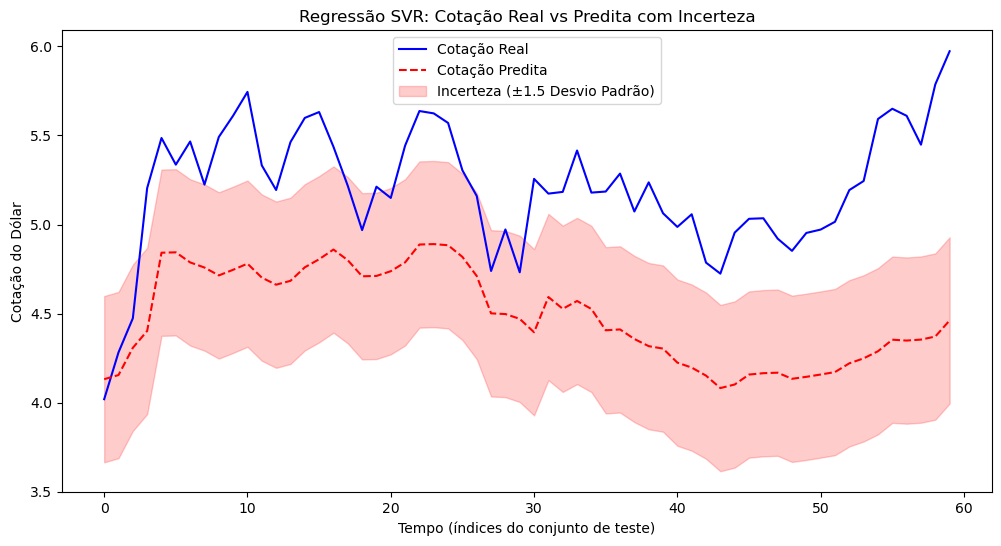

20
Melhores hiperparâmetros: OrderedDict({'C': 75.7323782310845, 'epsilon': 0.0001, 'gamma': 0.057969341670879124, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.09944165824764543
R² score: 0.8745062241473159


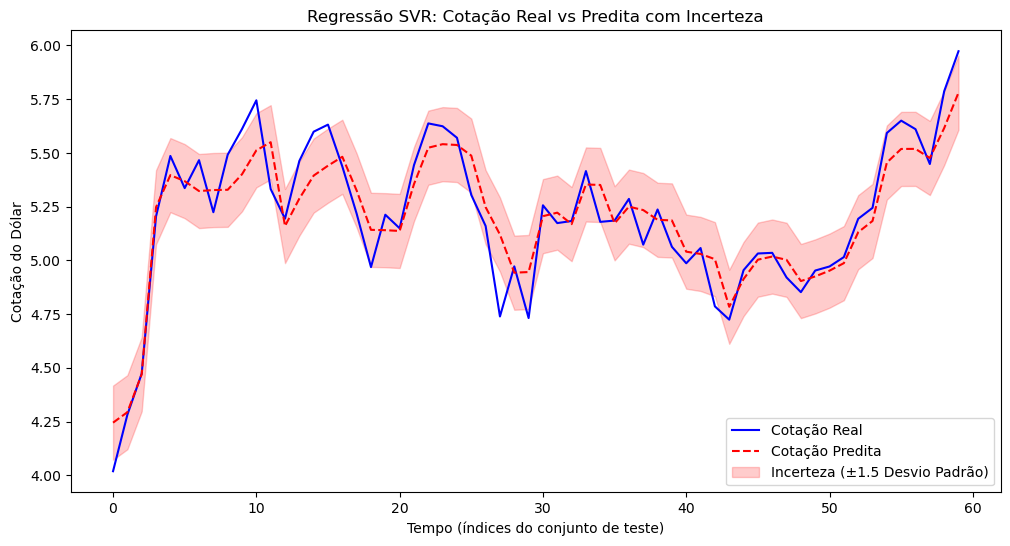

30
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.0001, 'gamma': 0.008819921723421395, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.10270820949058786
R² score: 0.8189570879630794


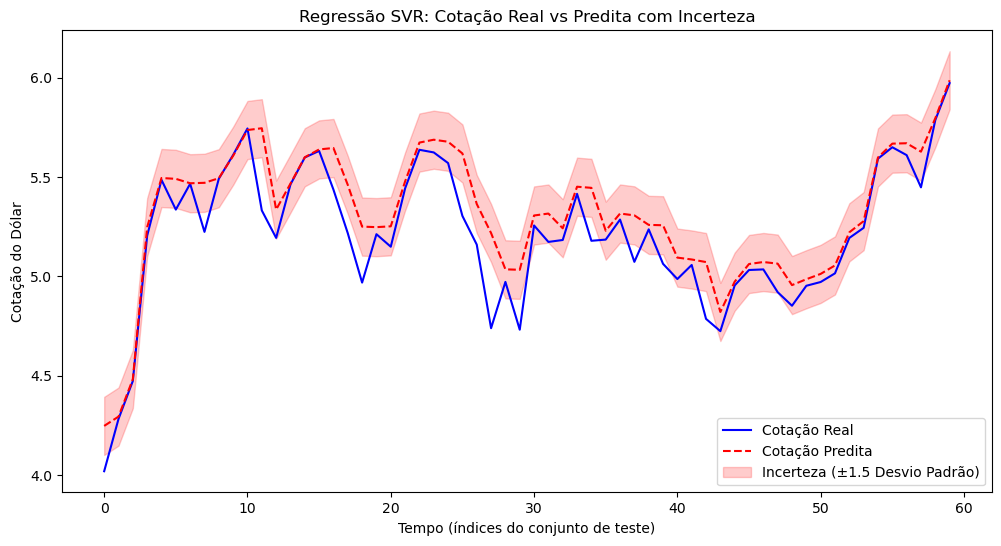

40
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.00013284335546342427, 'gamma': 0.00464792817946889, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.10594741664957584
R² score: 0.8122863604140054


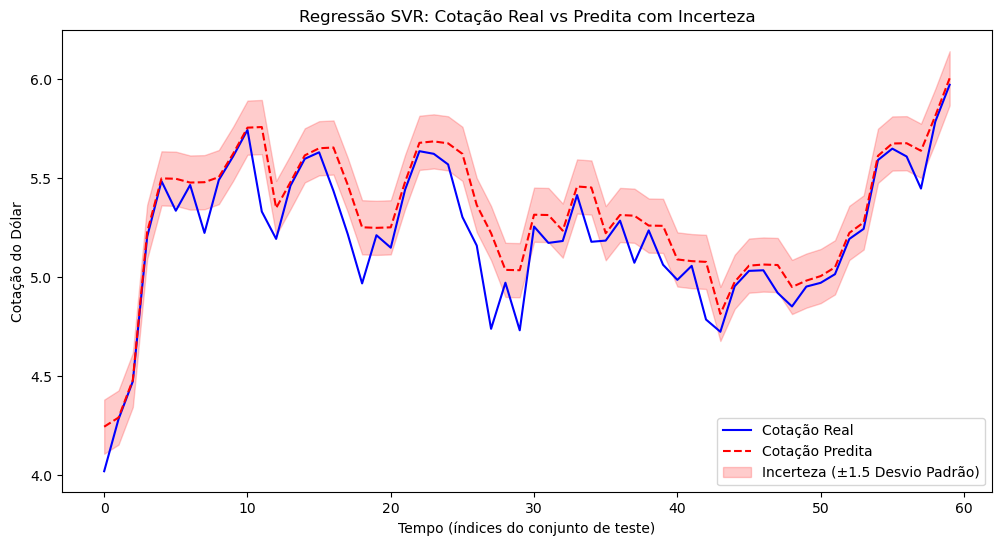

50
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.00013284335546342427, 'gamma': 0.00464792817946889, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.10594741664957584
R² score: 0.8122863604140054


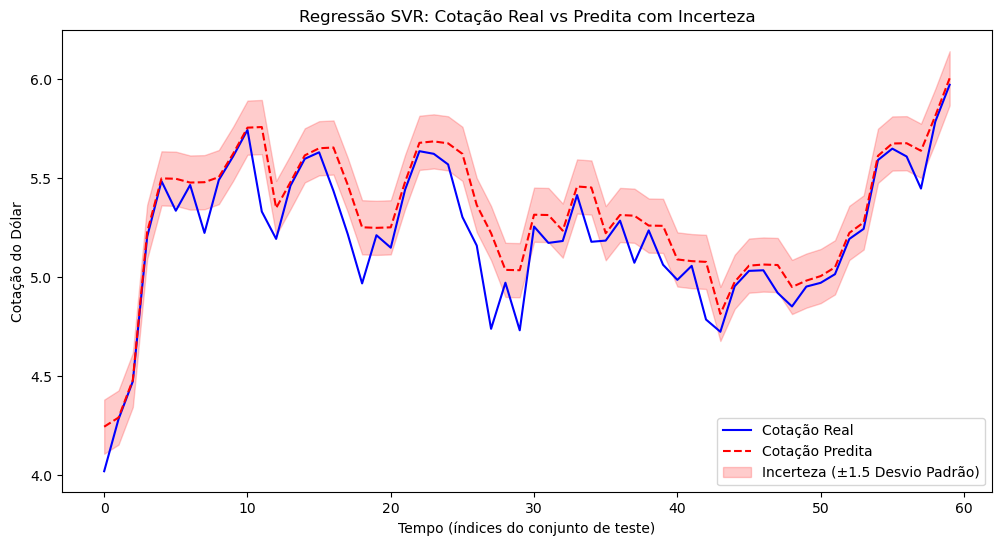

60
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.00013284335546342427, 'gamma': 0.00464792817946889, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.10594741664957584
R² score: 0.8122863604140054


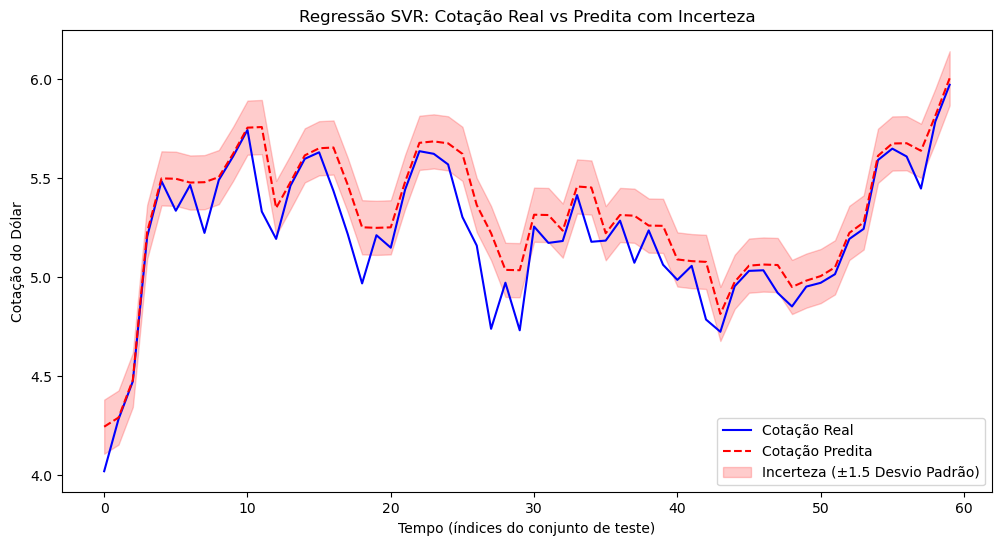

70
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.01996450440373296, 'gamma': 0.005259586588907692, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.08171529489031222
R² score: 0.8531446905999926


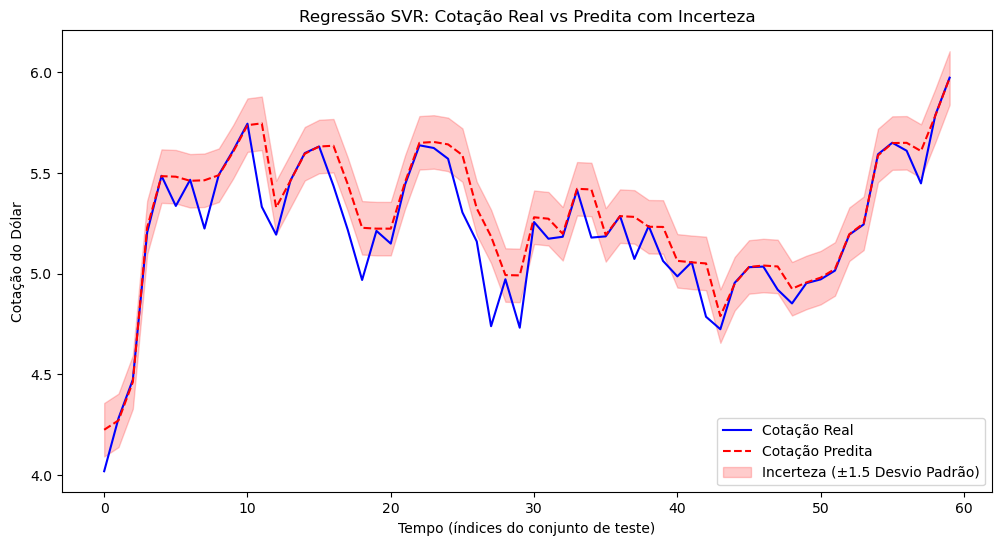

80
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.01996450440373296, 'gamma': 0.005259586588907692, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.08171529489031222
R² score: 0.8531446905999926


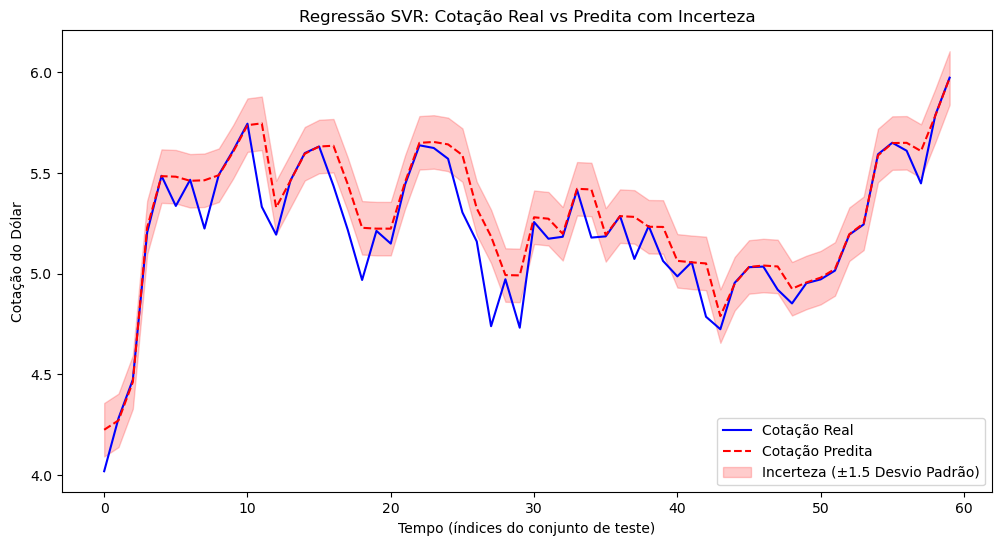

90
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.00021735083810897875, 'gamma': 0.003891690099181086, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.1069869740307098
R² score: 0.8104344855767954


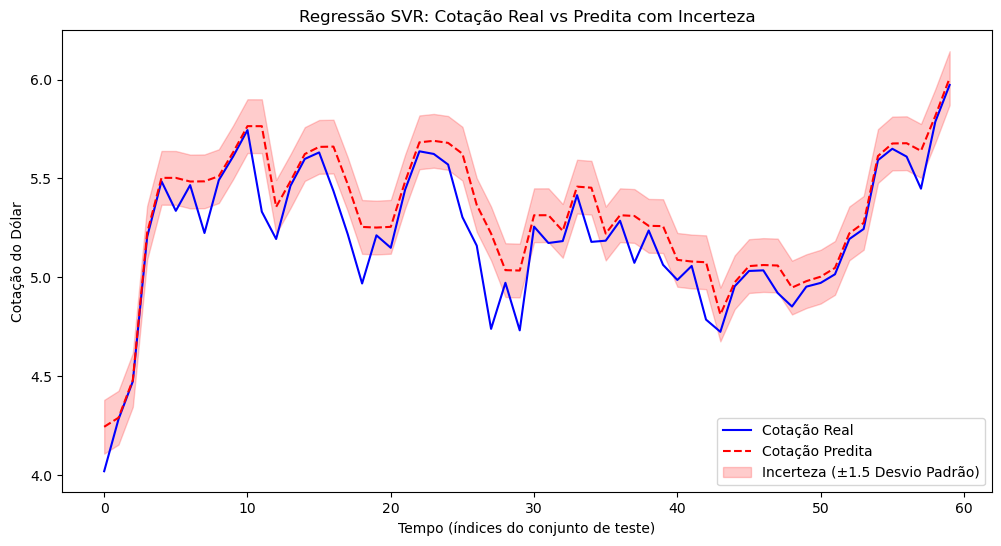

100
Melhores hiperparâmetros: OrderedDict({'C': 694.906327035747, 'epsilon': 0.009646288161878538, 'gamma': 0.006802802492578492, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.09462216118038129
R² score: 0.832605114417564


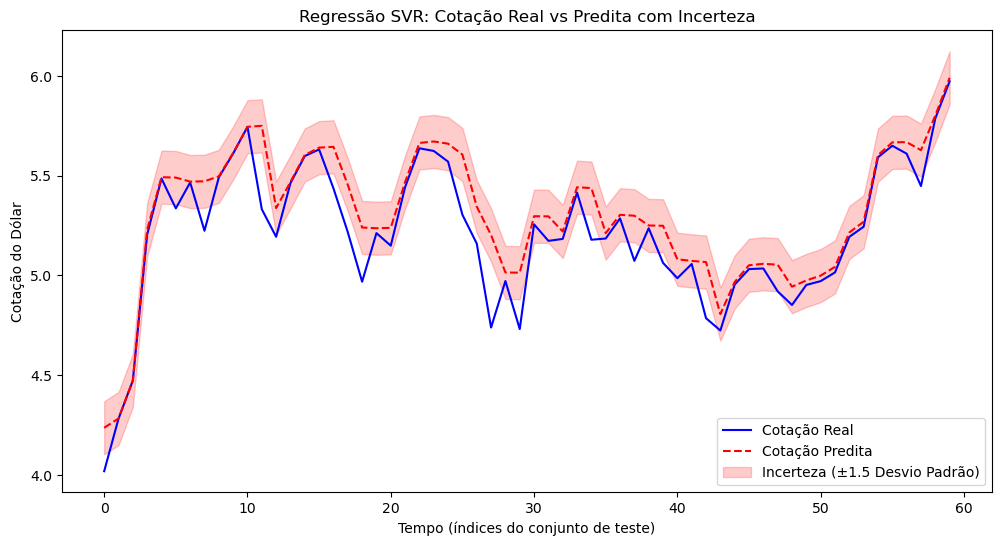

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]
# Criar novas features (médias móveis e desvio padrão)
df['rolling_mean_2'] = df['cotacao'].rolling(window=2).mean()
df['rolling_std_2'] = df['cotacao'].rolling(window=2).std()
df.fillna(0, inplace=True)  # Lidar com NaNs no início

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']
for i in range(10,110,10):
    #print(i+1,(i+1)*10)
    print(i)
    # Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Normalizar os dados com MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Definir o modelo SVR
    svr = SVR()
    
    # Definir os hiperparâmetros a serem otimizados
    param_grid = {
        'C': (0.1, 1000.0, 'log-uniform'),
        'epsilon': (0.0001, 1.0, 'log-uniform'),
        'gamma': (1e-5, 1.0, 'log-uniform'),
        'kernel': ['rbf', 'poly']  # Removemos 'sigmoid' por desempenho inferior
    }
    
    # Validação cruzada preservando ordem temporal
    tscv = TimeSeriesSplit(n_splits=5)
    # Otimização Bayesiana com TimeSeriesSplit e métrica R²
    bayes_search = BayesSearchCV(
        svr,
        param_grid,
        n_iter=i,  # Número de avaliações
        cv=tscv,  # Mantém a sequência temporal
        scoring='neg_mean_absolute_error', 
        n_jobs=-1,
        random_state=42
    )
    
    # Treinar o modelo
    bayes_search.fit(X_train_scaled, y_train)
    
    # Exibir melhores hiperparâmetros
    print("Melhores hiperparâmetros:", bayes_search.best_params_)
    
    # Avaliar no conjunto de teste
    best_svr = bayes_search.best_estimator_
    y_pred = best_svr.predict(X_test_scaled)
    
    # Calcular erro médio absoluto e R²
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Erro Médio Absoluto no Teste:", mae)
    print("R² score:", r2)
    
    # Estimativa da incerteza usando TimeSeriesSplit manualmente
    residuos = []
    for train_idx, test_idx in tscv.split(X_train_scaled):
        X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        best_svr.fit(X_fold_train, y_fold_train)  # Treinar no subconjunto
        y_fold_pred = best_svr.predict(X_fold_test)  # Fazer predição no subconjunto
        
        residuos.extend(y_fold_test - y_fold_pred)  # Armazenar os resíduos
    
    # Calcular desvio padrão dos resíduos
    std_dev = np.std(residuos)
    
    # Criar gráfico de predição vs. real
    mul_std = 1.5
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label="Cotação Real", color="blue")
    plt.plot(y_pred, label="Cotação Predita", color="red", linestyle="dashed")
    
    # Adicionar faixa de incerteza
    plt.fill_between(range(len(y_pred)), y_pred - mul_std*std_dev, y_pred + mul_std*std_dev, 
                     color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")
    
    # Configurações do gráfico
    plt.xlabel("Tempo (índices do conjunto de teste)")
    plt.ylabel("Cotação do Dólar")
    plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza")
    plt.legend()
    plt.show()


Rodando BayesSearchCV com 10 iterações
Melhores hiperparâmetros: OrderedDict({'C': 4.369339947510315, 'epsilon': 0.08145222883402799, 'gamma': 0.4616788656537451, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.7256281325729188
R² score: -3.7941806957212485
Rodando BayesSearchCV com 20 iterações
Melhores hiperparâmetros: OrderedDict({'C': 75.7323782310845, 'epsilon': 0.0001, 'gamma': 0.057969341670879124, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.09944165824764543
R² score: 0.8745062241473159
Rodando BayesSearchCV com 30 iterações
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.0001, 'gamma': 0.008819921723421395, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.10270820949058786
R² score: 0.8189570879630794
Rodando BayesSearchCV com 40 iterações
Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.00013284335546342427, 'gamma': 0.00464792817946889, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.10594741664957584
R² score: 0.8122863604140054
R

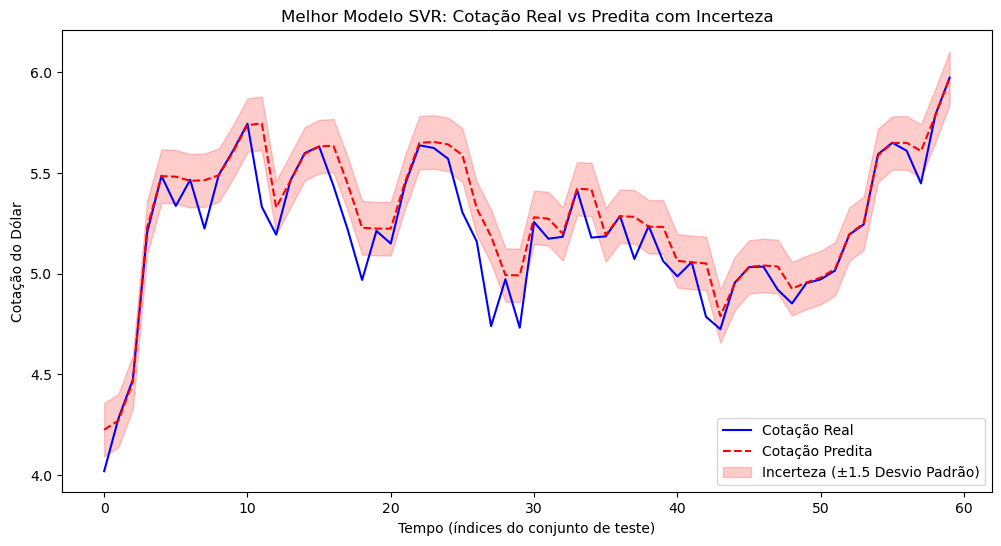

Melhor modelo salvo como 'melhor_modelo_svr.pkl'.


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import joblib  # For saving the best model

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]

# Criar novas features (médias móveis e desvio padrão)
df['rolling_mean_2'] = df['cotacao'].rolling(window=2).mean()
df['rolling_std_2'] = df['cotacao'].rolling(window=2).std()
df.fillna(0, inplace=True)  # Lidar com NaNs no início

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao', 't', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']

best_mae = float("inf")  # Inicializar o menor erro como infinito
best_model = None
best_X_test = None
best_y_test = None
best_y_pred = None
best_residuos = None
best_r2 = None
best_i = None
params = None

for i in range(10, 110, 10):
    print(f"Rodando BayesSearchCV com {i} iterações")

    # Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Normalizar os dados com MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Definir o modelo SVR
    svr = SVR()

    # Definir os hiperparâmetros a serem otimizados
    param_grid = {
        'C': (0.1, 1000.0, 'log-uniform'),
        'epsilon': (0.0001, 1.0, 'log-uniform'),
        'gamma': (1e-5, 1.0, 'log-uniform'),
        'kernel': ['rbf', 'poly']  # Mantemos apenas os melhores kernels
    }

    # Validação cruzada preservando ordem temporal
    tscv = TimeSeriesSplit(n_splits=5)

    # Otimização Bayesiana
    bayes_search = BayesSearchCV(
        svr,
        param_grid,
        n_iter=i,  # Número de avaliações
        cv=tscv,  # Mantém a sequência temporal
        scoring='neg_mean_absolute_error', 
        n_jobs=-1,
        random_state=42
    )

    # Treinar o modelo
    bayes_search.fit(X_train_scaled, y_train)

    # Exibir melhores hiperparâmetros
    print("Melhores hiperparâmetros:", bayes_search.best_params_)

    # Avaliar no conjunto de teste
    best_svr = bayes_search.best_estimator_
    y_pred = best_svr.predict(X_test_scaled)

    # Calcular erro médio absoluto e R²
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Erro Médio Absoluto no Teste:", mae)
    print("R² score:", r2)

    # Estimativa da incerteza usando TimeSeriesSplit
    residuos = []
    for train_idx, test_idx in tscv.split(X_train_scaled):
        X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        best_svr.fit(X_fold_train, y_fold_train)  # Treinar no subconjunto
        y_fold_pred = best_svr.predict(X_fold_test)  # Fazer predição no subconjunto

        residuos.extend(y_fold_test - y_fold_pred)  # Armazenar os resíduos

    # Salvar o melhor modelo se tiver o menor MAE
    if mae < best_mae:
        best_mae = mae
        best_r2 = r2
        best_model = best_svr
        best_X_test = X_test
        best_y_test = y_test
        best_y_pred = y_pred
        best_residuos = residuos
        best_i = i
        params = bayes_search.best_params_

# Após todas as iterações, gerar o gráfico para o melhor modelo
if best_model is not None:
    std_dev = np.std(best_residuos)
    print(f'\nMelhores params: {params}')
    print(f'MAE {best_mae}')
    print(f'R2 {best_r2}')
    print(f'best i {best_i}')
    # Criar gráfico de predição vs. real
    mul_std = 1.5
    plt.figure(figsize=(12, 6))
    plt.plot(best_y_test.values, label="Cotação Real", color="blue")
    plt.plot(best_y_pred, label="Cotação Predita", color="red", linestyle="dashed")

    # Adicionar faixa de incerteza
    plt.fill_between(range(len(best_y_pred)), best_y_pred - mul_std*std_dev, best_y_pred + mul_std*std_dev, 
                     color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

    # Configurações do gráfico
    plt.xlabel("Tempo (índices do conjunto de teste)")
    plt.ylabel("Cotação do Dólar")
    plt.title("Melhor Modelo SVR: Cotação Real vs Predita com Incerteza")
    plt.legend()
    plt.show()

    # Salvar o melhor modelo
    #joblib.dump(best_model, "melhor_modelo_svr.pkl")
    print("Melhor modelo salvo como 'melhor_modelo_svr.pkl'.")



Melhores hiperparâmetros: OrderedDict({'C': 1000.0, 'epsilon': 0.0001, 'gamma': 0.0013103207703656335, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.1362646350542059
R² score: 0.7905786742978005
Previsão para t+1: 5.9732356882383995


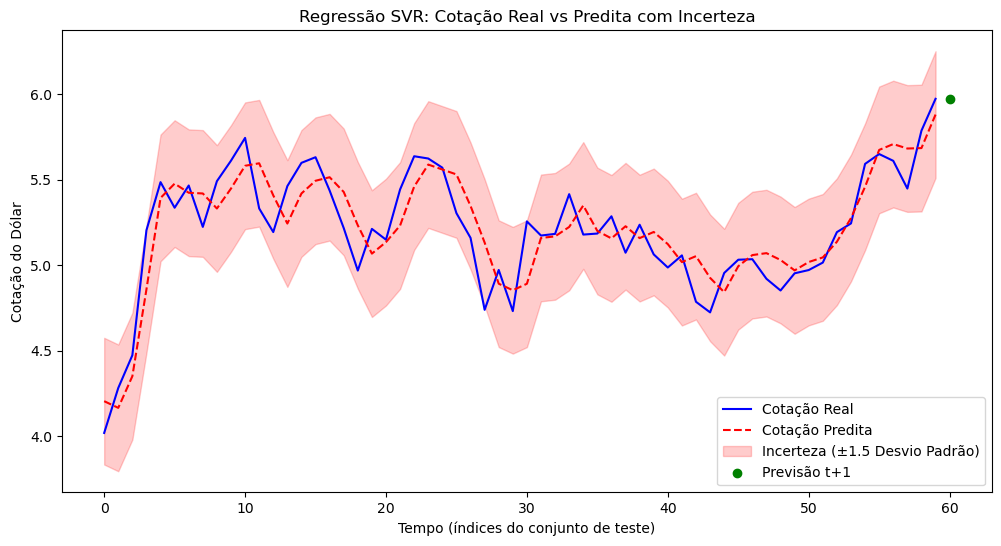

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)

# Criar novas features (médias móveis e desvio padrão)
df['rolling_mean_3'] = df['cotacao'].rolling(window=3).mean()
df['rolling_std_3'] = df['cotacao'].rolling(window=3).std()
df.fillna(0, inplace=True)  # Lidar com NaNs no início

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao', 't', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']

# Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir o modelo SVR
svr = SVR()

# Definir os hiperparâmetros a serem otimizados
param_grid = {
    'C': (0.1, 1000.0, 'log-uniform'),  # Regularization parameter
    'epsilon': (0.0001, 1.0, 'log-uniform'),  # Epsilon parameter
    'gamma': (1e-5, 1.0, 'log-uniform'),  # Kernel coefficient
    'kernel': ['rbf', 'poly']  # Removemos 'sigmoid' por desempenho inferior
}

# Validação cruzada preservando ordem temporal
tscv = TimeSeriesSplit(n_splits=5)

# Otimização Bayesiana com TimeSeriesSplit e métrica R²
bayes_search = BayesSearchCV(
    svr,
    param_grid,
    n_iter=40,  # Número de avaliações da busca bayesiana
    cv=tscv,  # Mantém a sequência temporal
    scoring='r2',  # Maximizar R²
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo com otimização Bayesiana
bayes_search.fit(X_train_scaled, y_train)

# Exibir melhores hiperparâmetros
print("Melhores hiperparâmetros:", bayes_search.best_params_)

# Avaliar no conjunto de teste
best_svr = bayes_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

# Calcular erro médio absoluto e R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Médio Absoluto no Teste:", mae)
print("R² score:", r2)

# Estimativa da incerteza usando TimeSeriesSplit manualmente
residuos = []
for train_idx, test_idx in tscv.split(X_train_scaled):
    X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    best_svr.fit(X_fold_train, y_fold_train)  # Treinar no subconjunto
    y_fold_pred = best_svr.predict(X_fold_test)  # Fazer predição no subconjunto
    
    residuos.extend(y_fold_test - y_fold_pred)  # Armazenar os resíduos

# Calcular desvio padrão dos resíduos
std_dev = np.std(residuos)

# Criar gráfico de predição vs. real
mul_std = 1.5
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Cotação Real", color="blue")
plt.plot(y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(range(len(y_pred)), y_pred - mul_std * std_dev, y_pred + mul_std * std_dev, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Previsão para t+1
X_t1_scaled = X_test_scaled[-1].reshape(1, -1)  # Última linha de X_test_scaled
y_pred_t1 = best_svr.predict(X_t1_scaled)
print(f"Previsão para t+1: {y_pred_t1[0]}")

# Adicionar previsão de t+1 no gráfico
plt.scatter(len(y_test), y_pred_t1, color="green", label="Previsão t+1", zorder=5)

# Configurações do gráfico
plt.xlabel("Tempo (índices do conjunto de teste)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza")
plt.legend()
plt.show()
